In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn import tree
import time
import re
import random
import numpy as np
from tqdm import tqdm
from tqdm import notebook

from sklearn.utils import shuffle

# лемматизация
import nltk
nltk.download('wordnet')
from nltk.corpus import stopwords
from pymystem3 import Mystem
import string
from string import punctuation
# подбор гиперпараметров
import optuna

#Модели обучения
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.decomposition import TruncatedSVD

# метрики
from sklearn.metrics import f1_score

%matplotlib inline
KFold = 5
RANDOM_STATE = 0

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Denis\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [19]:
df_sample = pd.read_csv("sample_submission.csv")

In [20]:
train = pd.read_csv("train_dataset_train.csv", parse_dates=['Дата_Рождения'])
test = pd.read_csv("test_dataset_test.csv", index_col='ID', parse_dates=['Дата_Рождения'])

In [23]:
train.head(5)

,ID,Код_группы,Год_Поступления,Пол,Основания,Изучаемый_Язык,Дата_Рождения,Уч_Заведение,Где_Находится_УЗ,Год_Окончания_УЗ,...,Общежитие,Наличие_Матери,Наличие_Отца,Страна_Родители,Опекунство,Село,Иностранец,КодФакультета,СрБаллАттестата,Статус
0,72716,16019,2015,Жен,ОО,Английский язык,1998-02-08,"МБОУ ""СОШ №59""","Алтайский край, Барнаул г",2014.0,...,0.0,0,0.0,Россия,0.0,0.0,0.0,41.0,4.294,3
1,63306,14895,2010,Муж,ЦН,NaN,1992-04-18,NaN,NaN,NaN,...,0.0,1,1.0,Россия,0.0,0.0,0.0,28.0,67.000,4
2,82469,20103,2017,Жен,ДН,Английский язык,1999-03-21,МБОУ Алтайская СОШ №5,"Алтайский край, Алтайский р-н, Алтайское с",2017.0,...,0.0,1,1.0,Россия,0.0,0.0,0.0,41.0,4.133,4
3,81661,19838,2017,Жен,БН,Английский язык,1994-12-08,ФГБОУ ВО Алтайский государственный университет,"Алтайский край, г. Барнаул",2017.0,...,0.0,1,1.0,Россия,0.0,0.0,0.0,35.0,74.000,4
4,81509,19803,2017,Жен,БН,Английский язык,1995-06-28,ФГБОУ ВО Алтайский государственный университет,"Алтайский край, г. Барнаул",2017.0,...,0.0,1,1.0,Россия,0.0,0.0,0.0,28.0,53.000,4


In [24]:
def data_info(df):
    """Функция первичного знакомства с данными"""
    display(df.head(10))
    print('Общая информация:')
    display(df.info())
    print('Общая статистика:')
    display(df.describe())
    print('Дубликаты:')
    display(df.duplicated().sum())
    print('Пропуски:')
    for col in df.columns:
        pct_missing = np.mean(df[col].isna())
        print('{} - {}%'.format(col, round(pct_missing*100,2)))
    print('Матрица диаграмм:')
    pd.plotting.scatter_matrix(df,figsize=(10,10))
    plt.suptitle("Матрица диаграмм зависимостей", size=20)
    plt.show()
    print('Heatmap корреляций:')
    plt.figure(figsize=(10, 10))
    heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True,cmap='BrBG') 
    heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':10}, pad=12);
    plt.show()
    print('Boxblot для оценки выбросов:')
    df.drop(columns='ID').plot(kind='box', 
    subplots=True, 
    sharey=False, 
    figsize=(15, 10)
    )

    # increase spacing between subplots
    plt.subplots_adjust(wspace=0.8) 
    plt.show()

In [25]:
data_info(train)

## Upsemple

In [26]:
train.Статус.value_counts()

 4    8249
 3    4721
-1     614
Name: Статус, dtype: int64

In [27]:
def upsample(X, y, repeat_one, repeat_three):
    
    '''
    Функция позмоляет увеличить количество 
    повторений одного из значений
    в данном случае значения 0
    '''
    X_one = X[y == -1]
    X_three = X[y == 3]
    X_four = X[y == 4]
    y_one = y[y == -1]
    y_three = y[y == 3]
    y_four = y[y == 4]

    features_upsampled = pd.concat([X_one] * repeat_one + [X_three] * repeat_three + [X_four])
    target_upsampled = pd.concat([y_one] * repeat_one + [y_three] * repeat_three + [y_four])
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=RANDOM_STATE)
    
    return features_upsampled, target_upsampled


In [28]:
train, train.Статус = upsample(train, train.Статус, 13, 2)

In [29]:
train.Статус.value_counts()

 4    8249
 3    4721
-1     614
Name: Статус, dtype: int64

In [30]:
train.index = train.ID
train.drop(columns=['ID'], inplace=True)
train_index = train.index
test_index = test.index

In [31]:
train = pd.concat([train, test])

In [32]:
train.shape, test.shape

((20275, 23), (6691, 22))

## Преобразование данных (train)

### Текстовые данные

In [33]:
object_list = train.select_dtypes(include=['object']).columns
train[object_list] = train[object_list].apply(lambda x:x.str.lower())
test[object_list] = test[object_list].apply(lambda x:x.str.lower())

In [34]:
train.select_dtypes(include=['object']).columns

Index(['Пол', 'Основания', 'Изучаемый_Язык', 'Уч_Заведение',
       'Где_Находится_УЗ', 'Страна_ПП', 'Регион_ПП', 'Город_ПП',
       'Страна_Родители'],
      dtype='object')

#### Основания

In [35]:
train['Основания'].unique()

array(['оо', 'цн', 'дн', 'бн', 'сн', 'лн'], dtype=object)

**Выволнено**

#### Изучаемый_Язык

In [36]:
train['Изучаемый_Язык'].unique()

array(['английский язык', nan, 'немецкий язык', 'французский язык',
       'русский язык', 'иностранный язык (английский)',
       'иностранный язык (немецкий)', 'англиийский',
       'английский, немецкий языки'], dtype=object)

In [37]:
train['Изучаемый_Язык'].fillna('английский язык', inplace=True)

In [38]:
index_1 = train[train['Изучаемый_Язык'] == 'иностранный язык (английский)'].index
train.loc[index_1, 'Изучаемый_Язык'] = 'английский язык'
index_2 = train[train['Изучаемый_Язык'] == 'иностранный язык (немецкий)'].index
train.loc[index_2, 'Изучаемый_Язык'] = 'немецкий язык'
index_3 = train[train['Изучаемый_Язык'] == 'англиийский'].index
train.loc[index_3, 'Изучаемый_Язык'] = 'английский язык'
index_4 = train[train['Изучаемый_Язык'] == 'английский'].index
train.loc[index_4, 'Изучаемый_Язык'] = 'английский язык'

In [39]:
train['Изучаемый_Язык'].unique()

array(['английский язык', 'немецкий язык', 'французский язык',
       'русский язык', 'английский, немецкий языки'], dtype=object)

**Выполнено**

#### Уч_Заведение

In [40]:
len(train['Уч_Заведение'].unique())

4650

In [41]:
train['Уч_Заведение'].fillna('российская сош', inplace=True)

In [42]:
train

,Код_группы,Год_Поступления,Пол,Основания,Изучаемый_Язык,Дата_Рождения,Уч_Заведение,Где_Находится_УЗ,Год_Окончания_УЗ,Пособие,...,Общежитие,Наличие_Матери,Наличие_Отца,Страна_Родители,Опекунство,Село,Иностранец,КодФакультета,СрБаллАттестата,Статус
ID,,,,,,,,,,,,,,,,,,,,,
72716,16019,2015,жен,оо,английский язык,1998-02-08,"мбоу ""сош №59""","алтайский край, барнаул г",2014.0,0.0,...,0.0,0,0.0,россия,0.0,0.0,0.0,41.0,4.294,3.0
63306,14895,2010,муж,цн,английский язык,1992-04-18,российская сош,NaN,NaN,0.0,...,0.0,1,1.0,россия,0.0,0.0,0.0,28.0,67.000,4.0
82469,20103,2017,жен,дн,английский язык,1999-03-21,мбоу алтайская сош №5,"алтайский край, алтайский р-н, алтайское с",2017.0,0.0,...,0.0,1,1.0,россия,0.0,0.0,0.0,41.0,4.133,4.0
81661,19838,2017,жен,бн,английский язык,1994-12-08,фгбоу во алтайский государственный университет,"алтайский край, г. барнаул",2017.0,0.0,...,0.0,1,1.0,россия,0.0,0.0,0.0,35.0,74.000,4.0
81509,19803,2017,жен,бн,английский язык,1995-06-28,фгбоу во алтайский государственный университет,"алтайский край, г. барнаул",2017.0,0.0,...,0.0,1,1.0,россия,0.0,0.0,0.0,28.0,53.000,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74342,20680,2016,муж,бн,английский язык,1992-03-06,гу павлодарский профессиональный лицей №7,"казахстан, павлодарская обл, г павлодар",2011.0,0.0,...,1.0,1,1.0,казахстан,0.0,0.0,1.0,34.0,77.000,NaN
54876,16921,2013,жен,оо,английский язык,1995-11-08,российская сош,NaN,NaN,0.0,...,0.0,1,1.0,россия,0.0,0.0,0.0,36.0,62.000,NaN
66879,19400,2014,жен,сн,английский язык,1996-03-31,"мбоу ""гимназия №42""","алтайский край, барнаул г",2014.0,0.0,...,0.0,0,0.0,россия,0.0,0.0,0.0,26.0,52.000,NaN


In [43]:
train['Уч_Заведение']

ID
72716                                       мбоу "сош №59"
63306                                       российская сош
82469                                мбоу алтайская сош №5
81661       фгбоу во алтайский государственный университет
81509       фгбоу во алтайский государственный университет
                               ...                        
74342            гу павлодарский профессиональный лицей №7
54876                                       российская сош
66879                                  мбоу "гимназия №42"
64982                              мбоу "ребрихинская сош"
69975    фгбоу впо "алтайский государственный университет"
Name: Уч_Заведение, Length: 20275, dtype: object

In [44]:
if __name__ == '__main__':
    new_values = []
    for text in train['Уч_Заведение']:
        s = text
 
        chars = '[%s]+' % re.escape(string.punctuation)
        s = re.sub(chars, '', s)
        new_values.append(s)
        
train['Уч_Заведение'] = new_values

In [45]:
train['Уч_Заведение']

ID
72716                                       мбоу сош №59
63306                                     российская сош
82469                              мбоу алтайская сош №5
81661     фгбоу во алтайский государственный университет
81509     фгбоу во алтайский государственный университет
                              ...                       
74342          гу павлодарский профессиональный лицей №7
54876                                     российская сош
66879                                  мбоу гимназия №42
64982                              мбоу ребрихинская сош
69975    фгбоу впо алтайский государственный университет
Name: Уч_Заведение, Length: 20275, dtype: object

**Возможны доработки. Типизировать названия школ проживания**

#### Где_Находится_УЗ

In [46]:
train['Где_Находится_УЗ'].unique()

array(['алтайский край, барнаул г', nan,
       'алтайский край, алтайский р-н, алтайское с', ...,
       'алтайский край, локтевский р-н, гилево c',
       'алтайский край, тюменцевский р-н, карповский п', 'кнр, хэйхэ г'],
      dtype=object)

In [47]:
len(train['Где_Находится_УЗ'].unique())

2666

In [48]:
train['Где_Находится_УЗ'].fillna('г барнаул алтайский край', inplace=True)

In [49]:
if __name__ == '__main__':
    new_values = []
    for text in train['Где_Находится_УЗ'].sort_values():
        s = text
 
        chars = '[%s]+' % re.escape(string.punctuation)
        s = re.sub(chars, '', s)
        new_values.append(s)
        
train['Где_Находится_УЗ'] = np.array(new_values)

#Create lemmatizer and stopwords list
mystem = Mystem() 
russian_stopwords = stopwords.words("russian")

#Preprocess function
def preprocess_text(text):
    tokens = mystem.lemmatize(text.lower())
    tokens = [token for token in tokens if token not in russian_stopwords\
              and token != " " \
              and token.strip() not in punctuation]
    
    text = " ".join(tokens)
    
    return text


**Возможны доработки. Типизировать названия регионов проживания**

#### Страна_ПП

In [50]:
train['Страна_ПП'].unique()

array(['россия', nan, 'казахстан', 'кыргызстан', 'китай', 'таджикистан',
       'казахстан респ', 'киргизия', 'армения', 'туркменистан', 'нигерия',
       'таджикистан респ', 'росссия', 'узбекистан', 'кыргызия', 'франция',
       'кыргызская республика', 'монголия', 'казахстан вко',
       'республика казахстан', 'республика таджикистан', 'украина',
       'афганистан'], dtype=object)

In [51]:
rus_list = [' г барнаул алтайского края', ' омская область омск г', 'алейск',
       'алейск алтайского края', 'алтай респ горноалтайск г',
       'алтай респ кошагачский рн кошагач с',
       'алтай респ кошагачский рон тобелер с', 'алтайский край алейск г',
       'алтайский край баевский рн', 'алтайский край барнаул',
       'алтайский край барнаул г', 'алтайский край бийск г',
       'алтайский край благовещенский рн степное озеро рп',
       'алтайский край быстроистокский рн быстрый исток с',
       'алтайский край г барнаул', 'алтайский край г белокуриха',
       'алтайский край г бийск', 'алтайский край г заринск',
       'алтайский край г рубцовск', 'алтайский край гбарнаул',
       'алтайский край гор бийск', 'алтайский край заринский рн тягун ст',
       'алтайский край зато сибирский', 'алтайский край змеиногорский рн',
       'алтайский край зональный рн буланиха с',
       'алтайский край калманский рн новороманово с',
       'алтайский край каменьнаоби г',
       'алтайский край косихинский рн налобиха с',
       'алтайский край красногорский рн красногорское с',
       'алтайский край красногорский рн соусканиха с',
       'алтайский край краснощековский рн маралиха с',
       'алтайский край краснощёковский рн',
       'алтайский край кулундинский район',
       'алтайский край кулундинский рн кулунда с',
       'алтайский край новичихинский рн новичиха с',
       'алтайский край новоалтайск г',
       'алтайский край павловский рн шахи с',
       'алтайский край первомайский рн бобровка с',
       'алтайский край первомайский рн боровиха с',
       'алтайский край первомайский рн северный п',
       'алтайский край романовский рн романово с',
       'алтайский край рубцовск г', 'алтайский край с знаменки',
       'алтайский край сибирский зато', 'алтайский край славгород г',
       'алтайский край советский рн никольское с',
       'алтайский край солонешенский район ссолонешное',
       'алтайский край тальменский рн тальменка рп',
       'алтайский край хабарский рн хабары с',
       'алтайский край шипуновский рн шипуново с', 'английский язык',
               'баевский рон', 'барнаул', 'барнаул алтайский край', 'г барнаул',
       'г барнаул алтайский край', 'г барнаул алтайского края',
       'г заринск', 'г змеиногорск', 'г москва', 'г яровое алтайского края', 'гбарнаул', 'гбарнаул алтайский край',
       'гбийск', 'гновоалтайск алтайского края',
       'город барнаул алтайского края', 'город славгород алтайского края','москва г',
       'московская обл москва г', 'новосибирская обл бердск г',
       'новосибирская область г новосибирск', 'пурожайный',
       'ребрихинский район алтайского края',
       'республика алтай улаганский район',
       'россия алтайский край благовещенский рн рп степное озеро',
       'россия алтайский край волчихинский рн',
       'россия алтайский край г барнаул', 'россия алтайский край г бийск',
       'россия алтайский край г новоалтайск',
       'россия алтайский край змеиногорский рн',
       'россия алтайский край зональный рн с луговское',
       'россия алтайский край новочихинский рн с новочиха',
       'россия алтайский край родинский рн с родино',
       'россия алтайский край тальменский рн с новоперуново',
       'россия алтайский край третьяковский рн',
       'россия алтайский край угловский рн', 'россия г москва',
       'россия новосибирская обл г новосибирск',
       'россия республика алтай г горноалтайск',
       'с гилевлог романовского рна', 'с гилёвлог романовского рна',
       'с черемное павловского рна алтайского края',
       'скрутиха крутихинского рна алтайского края','томская область г томск', 'устьордынка с'
               ]

In [52]:
kaz_list = ['г шемонаиха вко',
            'казахстан восточноказахстанская обл бородулихинский рн п жезкент',
       'казахстан восточноказахстанская обл г риддер',
       'казахстан восточноказахстанская обл г семей',
       'казахстан восточноказахстанская обл г шемонаиха',
       'казахстан г устькаменогорск',
       'казахстан респ восточноказахстанская обл глубоковский рн глубокое п',
       'казахстан респ восточноказахстанская обл риддер г', 'казахстан вко'
            
               ]

In [53]:
china_list = [
    'китай ггуанхань',
       'китай ляонин провинция г инкоу', 'китай синьцзян г',
]

In [54]:
kirgiz_list = [
    'киргизия нарынская обл атбашинский рн',
    'кыргызская респ жалалабадская обл', 'киргизия'
]

In [55]:
tadjik_list = ['таджикистан г душанбе', 'таджикистан респ джаломеддина рулей',
       'таджикистан респ худжанд г', 'таджикистан худжанд г', 'таджикистан респ']

In [56]:
rus_index = train.query("Где_Находится_УЗ in @rus_list")['Страна_ПП'].index
kaz_index = train.query("Где_Находится_УЗ in @kaz_list")['Страна_ПП'].index
china_index = train.query("Где_Находится_УЗ in @china_list")['Страна_ПП'].index
kirgiz_index = train.query("Где_Находится_УЗ in @kirgiz_list")['Страна_ПП'].index
tadjik_index = train.query("Где_Находится_УЗ in @tadjik_list")['Страна_ПП'].index

In [57]:
train.loc[rus_index,'Страна_ПП'] = 'россия'
train.loc[kaz_index,'Страна_ПП'] = 'казахстан'
train.loc[china_index,'Страна_ПП'] = 'китай'
train.loc[kirgiz_index,'Страна_ПП'] = 'кыргызия'
train.loc[tadjik_index,'Страна_ПП'] = 'таджикистан'

In [58]:
train['Страна_ПП'].unique()

array(['россия', nan, 'казахстан', 'кыргызстан', 'китай', 'таджикистан',
       'киргизия', 'монголия', 'кыргызия', 'таджикистан респ',
       'казахстан вко', 'казахстан респ', 'кыргызская республика',
       'узбекистан', 'туркменистан'], dtype=object)

In [59]:
kaz_index = train[train['Страна_ПП'].isin(['казахстан респ', 'республика казахстан', 'казахстан вко'])].index
tadjik_index = train[train['Страна_ПП'].isin(['республика таджикистан', 'таджикистан респ'])].index
kirgiz_index = train[train['Страна_ПП'].isin(['кыргызская республика', 'кыргызстан', 'киргизия'])].index

In [60]:
train.loc[kaz_index,'Страна_ПП'] = 'казахстан'
train.loc[kirgiz_index,'Страна_ПП'] = 'кыргызия'
train.loc[tadjik_index,'Страна_ПП'] = 'таджикистан'

In [61]:
train['Страна_ПП'].fillna('россия', inplace=True)

In [62]:
train['Страна_ПП'].unique()

array(['россия', 'казахстан', 'кыргызия', 'китай', 'таджикистан',
       'монголия', 'узбекистан', 'туркменистан'], dtype=object)

#### Регион_ПП

In [63]:
train['Регион_ПП'].isna().sum()

908

In [64]:
train['Регион_ПП'].fillna('алтайский край', inplace=True)

In [65]:
display(train[['Регион_ПП', 'Страна_ПП']].head(100))

,Регион_ПП,Страна_ПП
ID,,
72716,алтайский край,россия
63306,алтайский край,россия
82469,алтайский край,россия
81661,алтайский край,россия
81509,алтайский край,россия
...,...,...
86329,алтайский край,россия
68579,алтайский край,россия
65463,алтайский край,россия


**Ведутся работы** (имеются несоответствия страны_ПП и региона_ПП)

#### Город_ПП

In [66]:
len(train['Город_ПП'].unique())

2213

In [67]:
train['Город_ПП'].isna().sum()

657

In [68]:
train['Город_ПП'].fillna('барнаул', inplace=True)

**Ведутся работы**

#### Страна_Родители

In [69]:
train['Страна_Родители'].isna().sum()

656

In [70]:
kaz_index = train[train['Страна_Родители'].isin(['казахстан респ', 'республика казахстан', 'казахстан вко'])].index
tadjik_index = train[train['Страна_Родители'].isin(['республика таджикистан'])].index
kirgiz_index = train[train['Страна_Родители'].isin(['кыргызская республика', 'кыргызстан', 'киргизия'])].index

china_index = train[train['Страна_Родители'].isin(['кнр'])].index
moldova_index = train[train['Страна_Родители'].isin(['республика молдова'])].index

In [71]:
train.loc[kaz_index,'Страна_Родители'] = 'казахстан'
train.loc[kirgiz_index,'Страна_Родители'] = 'кыргызия'
train.loc[tadjik_index,'Страна_Родители'] = 'таджикистан'

train.loc[china_index,'Страна_Родители'] = 'китай'
train.loc[moldova_index,'Страна_Родители'] = 'молдова'

In [72]:
train['Страна_Родители'].unique()

array(['россия', nan, 'кыргызия', 'казахстан', 'китай', 'таджикистан',
       'туркменистан', 'германия', 'армения', 'молдова', 'нигерия',
       'узбекистан', 'монголия', 'украина', 'афганистан',
       'чеченская республика'], dtype=object)

In [73]:
train['Страна_Родители'].fillna('россия', inplace=True)

In [74]:
train[train['Страна_Родители'].isna() == True]

,Код_группы,Год_Поступления,Пол,Основания,Изучаемый_Язык,Дата_Рождения,Уч_Заведение,Где_Находится_УЗ,Год_Окончания_УЗ,Пособие,...,Общежитие,Наличие_Матери,Наличие_Отца,Страна_Родители,Опекунство,Село,Иностранец,КодФакультета,СрБаллАттестата,Статус
ID,,,,,,,,,,,,,,,,,,,,,


**Ведутся работы**

#### Промежуточные итоги

### Числовые данные

In [75]:
train.select_dtypes(exclude=['object', 'datetime64[ns]']).columns

Index(['Код_группы', 'Год_Поступления', 'Год_Окончания_УЗ', 'Пособие',
       'Общежитие', 'Наличие_Матери', 'Наличие_Отца', 'Опекунство', 'Село',
       'Иностранец', 'КодФакультета', 'СрБаллАттестата', 'Статус'],
      dtype='object')

#### СрБаллАттестата (остановился тут)

In [76]:
index = train[train['СрБаллАттестата'] > 100.0]['СрБаллАттестата'].index

In [77]:
train.loc[index, 'СрБаллАттестата'] = round(train.loc[index, 'СрБаллАттестата'] / 100)

In [78]:
train.loc[index, 'СрБаллАттестата']

ID
66693    47.0
80038    32.0
74472    49.0
85029    45.0
52248    42.0
         ... 
84525    34.0
71361    49.0
81103    50.0
47811    49.0
75854    39.0
Name: СрБаллАттестата, Length: 78, dtype: float64

<AxesSubplot:>

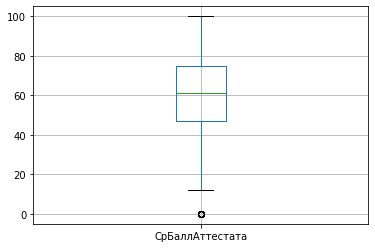

In [157]:
train[['СрБаллАттестата']].boxplot()

In [80]:
train[train['СрБаллАттестата'] == 100]

,Код_группы,Год_Поступления,Пол,Основания,Изучаемый_Язык,Дата_Рождения,Уч_Заведение,Где_Находится_УЗ,Год_Окончания_УЗ,Пособие,...,Общежитие,Наличие_Матери,Наличие_Отца,Страна_Родители,Опекунство,Село,Иностранец,КодФакультета,СрБаллАттестата,Статус
ID,,,,,,,,,,,,,,,,,,,,,
48494,14662,2012,жен,сн,английский язык,1993-11-15,российская сош,алтай респ горноалтайск г,NaN,0.0,...,0.0,1,1.0,россия,0.0,0.0,0.0,24.0,100.0,4.0
65377,15421,2014,жен,оо,немецкий язык,1993-03-14,фгбоу впо алтайский государственный университет,алтай респ улаганский рн саратан с,2014.0,0.0,...,0.0,0,0.0,россия,0.0,0.0,0.0,51.0,100.0,4.0
59711,12813,2013,жен,дн,английский язык,1970-12-18,устькаменогорский педагогический институт,алтайски край г барнаул,1992.0,NaN,...,0.0,0,0.0,россия,0.0,1.0,NaN,45.0,100.0,3.0
64918,18149,2014,жен,оо,английский язык,1996-01-21,мбоу чарышская сош,алтайский край,2013.0,0.0,...,1.0,0,0.0,россия,0.0,1.0,0.0,27.0,100.0,4.0
80908,19871,2017,жен,бн,английский язык,1995-06-21,фгбоу во алтайский государственный университет,алтайский край г барнаул,2017.0,0.0,...,0.0,1,1.0,россия,0.0,0.0,0.0,27.0,100.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87082,21062,2018,жен,бн,английский язык,1989-06-10,фгбоу впо алтайский государственный университет,с славгородское г славгорода алтайского края,2011.0,0.0,...,0.0,1,1.0,россия,0.0,0.0,0.0,51.0,100.0,NaN
56959,14818,2013,жен,сн,английский язык,1992-06-04,фгбоу впо алтайский государственный университет,с топольное солонешенского рна алтайский край,2013.0,NaN,...,0.0,0,0.0,россия,0.0,1.0,NaN,26.0,100.0,NaN
68818,15638,2014,муж,сн,английский язык,1990-03-25,горноалтайский государственный политехнический...,санктпетербург,2010.0,NaN,...,0.0,0,0.0,россия,0.0,1.0,0.0,45.0,100.0,NaN


In [81]:
index = train[train['СрБаллАттестата'] < 11].index
train.loc[index, 'СрБаллАттестата'] = train.loc[index, 'СрБаллАттестата'] * 10

In [82]:
# для данных у которых оценка за средний бал аттестата 0 создадим бинарную колонку отталкиваясь от логики
train['ЕГЭ_не_сдавался'] = None

In [83]:
index = train[train['СрБаллАттестата'] == 0].index
train.loc[index, 'ЕГЭ_не_сдавался'] = 1
train['ЕГЭ_не_сдавался'] = train['ЕГЭ_не_сдавался'].fillna(0)

#### Год_Окончания_УЗ

In [84]:
# заменили пропуски средним временем которое нужно человеку от рождения до окончания среднего УЗ (7 лет + 11 лет обучения)
index = train[train['Год_Окончания_УЗ'].isna() == True].index
train.loc[index,'Год_Окончания_УЗ'] = train.loc[index ,'Дата_Рождения'].dt.year + 7 + 11

#### Пособие

In [85]:
train['Пособие'].fillna(0, inplace=True)

#### Общежитие

In [86]:
train['Общежитие'].fillna(0, inplace=True)

#### Село

In [87]:
train['Село'].fillna(0, inplace=True)

#### Иностранец

In [89]:
train['Иностранец'].value_counts()

0.0    18432
1.0     1403
Name: Иностранец, dtype: int64

In [90]:
index = train[train['Страна_ПП'] != 'россия']['Иностранец'].index
train.loc[:, 'Иностранец'] = 0
train.loc[index, 'Иностранец'] = 1

In [91]:
train['Иностранец'].value_counts()

0    19707
1      568
Name: Иностранец, dtype: int64

#### Пол

In [92]:
index = train[train['Пол'].isna() == True].index
#train.loc[index, 'Пол'] = train.loc[index, 'Пол'].apply(random.choice(['муж', 'жен']))

In [93]:
train.loc[index, 'Пол'] = train.loc[index, 'Пол'].apply(lambda x: random.choice(['муж', 'жен']))

#### Год поступления

In [94]:
# удалить выбросы
train.query("Год_Окончания_УЗ in [1993., 1985., 1982., 1973., 1974., 1983., 1979]")[['Год_Поступления', 'Год_Окончания_УЗ']]

,Год_Поступления,Год_Окончания_УЗ
ID,,
56392,2007,1993.0
76413,2016,1993.0
70094,2015,1993.0
70536,2015,1985.0
53214,2012,1993.0
77060,2016,1982.0
52398,2013,1985.0
65502,2014,1985.0
70089,2015,1985.0


In [95]:
train[['Год_Поступления', 'Год_Окончания_УЗ']].groupby(by='Год_Окончания_УЗ').agg({'Год_Поступления':('max', 'min')})

Год_Поступления      
                             max   min
Год_Окончания_УЗ                      
1966.0                      2015  2015
1973.0                      2017  2017
1974.0                      2014  2014
1977.0                      2012  2012
1979.0                      2015  2013
1980.0                      2013  2013
1981.0                      2016  2015
1982.0                      2019  2013
1983.0                      2015  2012
1984.0                      2018  2012
1985.0                      2017  2005
1986.0                      2017  2011
1987.0                      2015  2013
1988.0                      2018  2013
1989.0                      2015  2012
1990.0                      2018  2013
1991.0                      2017  2012
1992.0                      2018  2010
1993.0                      2019  2007
1994.0                      2019  2012
1995.0                      2020  2012
1996.0                      2018  2012
1997.0                      2019  2012
1998.0                      2019  2010
1999.0                      2019  2007
2000.0                      2019  2010
2001.0                      2019  2010
2002.0                      2019  2009
2003.0                      2019  2001
2004.0                      2019  2010
2005.0                      2019  2004
2006.0                      2020  2009
2007.0                      2019  2007
2008.0                      2019  2007
2009.0                      2212  2008
2010.0                      2020  2007
2011.0                      2019  2010
2012.0                      2020  2011
2013.0                      2020  2003
2014.0                      2020  2012
2015.0                      2020  2013
2016.0                      2020  2014
2017.0                      2020  2012
2018.0                      2020  2012
2019.0                      2020  2019
2020.0                      2020  2020

In [96]:
train.select_dtypes(exclude=['object', 'datetime64[ns]']).columns

Index(['Код_группы', 'Год_Поступления', 'Год_Окончания_УЗ', 'Пособие',
       'Общежитие', 'Наличие_Матери', 'Наличие_Отца', 'Опекунство', 'Село',
       'Иностранец', 'КодФакультета', 'СрБаллАттестата', 'Статус',
       'ЕГЭ_не_сдавался'],
      dtype='object')

In [97]:
# удалить выбросы
train['Год_Поступления'].unique()

array([2015, 2010, 2017, 2013, 2014, 2016, 2018, 2012, 2019, 2020, 2212,
       2011, 2009, 2007, 2008, 2001, 2004, 2005, 2003, 2006], dtype=int64)

In [98]:
index = train[train['Год_Поступления'] == 2212].index
train.loc[index, 'Год_Поступления'] = train.loc[index, 'Год_Поступления'] - 100

## Работа с пропусками

In [101]:
train.shape

(20275, 24)

### Очистка признаков Город_ПП, Страна_ПП, Где_Находится_УЗ

In [103]:
def preprocess_text(text):
    # удаление цифр и пунктуации, кроме апострофа
    text = re.sub(r"[^а-яА-Я']", " ", text)
    text = re.sub(r"[гс]\s", " ", text)
    text = re.sub(r"\s[гс]", " ", text)
    # циклом пройдёмся дважды по тексту, чтобы гарантированно удалить одинокостоящие символы
           
    for _ in range(2):
        # удаление одинокостоящих символов
        text = re.sub(r"\s+[а-яА-Я]\s+", ' ', text)
    
        
    
        # удаление множественных пробелов
    text = text.strip()
    return text

In [104]:
train['Город_ПП'].fillna('барнаул', inplace=True)

In [105]:
train[train['Страна_ПП'] == 'россия'][['Город_ПП', 'Страна_ПП']].groupby(by='Город_ПП').agg('count').sort_values(by='Страна_ПП')

,Страна_ПП
Город_ПП,
онгудай,1
с бора-тайга,1
с алтайское,1
с .ребриха,1
рыбное каменского района,1
...,...
новоалтайск г,283
бийск г,362
барнаул,2364


In [106]:
tqdm.pandas(desc="progress bar!")

train['Город_ПП'] = train['Город_ПП'].progress_apply(preprocess_text)
train['Где_Находится_УЗ'] = train['Где_Находится_УЗ'].progress_apply(preprocess_text)
train['Уч_Заведение'] = train['Уч_Заведение'].progress_apply(preprocess_text)

progress bar!: 100%|██████████████████████████████████████████████████████████| 20275/20275 [00:00<00:00, 78795.37it/s]


### Кодирование TF-IDF и снижение размерности SVD

In [107]:
# функция векторизации и снижение размерности
def vectorizer(dataset, Series_name):
    vectorizer = TfidfVectorizer(max_df=0.5)
    vector = vectorizer.fit_transform(list(dataset[Series_name]))
    SVD = TruncatedSVD()
    vector = SVD.fit_transform(vector)

    return vector[:, 0], vector[:, 1]
    #return vector

In [108]:
train['Где_Находится_УЗ_1'], train['Где_Находится_УЗ_2'] = (vectorizer(train, 'Где_Находится_УЗ'))
train['Уч_Заведение_1'], train['Уч_Заведение_2'] = (vectorizer(train, 'Уч_Заведение'))
train['Регион_ПП_1'], train['Регион_ПП_2'] = (vectorizer(train, 'Регион_ПП'))
train['Город_ПП_1'], train['Город_ПП_2'] = (vectorizer(train, 'Город_ПП'))

# train[['Уч_Заведение_1', 'Уч_Заведение_2']] = zip(vectorizer(train, 'Уч_Заведение'))
# train[['Регион_ПП_1', 'Регион_ПП_2']] = zip(vectorizer(train, 'Регион_ПП'))
# train[['Город_ПП_1', 'Город_ПП_2']] = zip(vectorizer(train, 'Город_ПП'))
# удалим преобразованные колонки
train.drop(columns=['Где_Находится_УЗ', 'Уч_Заведение', 'Регион_ПП', 'Город_ПП'], inplace=True)

In [109]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20275 entries, 72716 to 69975
Data columns (total 28 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Код_группы          20275 non-null  int64         
 1   Год_Поступления     20275 non-null  int64         
 2   Пол                 20275 non-null  object        
 3   Основания           20275 non-null  object        
 4   Изучаемый_Язык      20275 non-null  object        
 5   Дата_Рождения       20275 non-null  datetime64[ns]
 6   Год_Окончания_УЗ    20275 non-null  float64       
 7   Пособие             20275 non-null  float64       
 8   Страна_ПП           20275 non-null  object        
 9   Общежитие           20275 non-null  float64       
 10  Наличие_Матери      20275 non-null  int64         
 11  Наличие_Отца        20275 non-null  float64       
 12  Страна_Родители     20275 non-null  object        
 13  Опекунство          20275 non-null  float6

### One Hot Encoder

In [110]:
def encoder(dataset, Series_name):
    new_dict = {}
    encoder = OneHotEncoder(
                       sparse=True, # Will return sparse matrix if set True
                       handle_unknown='error')
    
    columns = dataset[Series_name].unique()
    transformed = encoder.fit_transform(dataset[[Series_name]]).toarray()
    
    i = 0
    for column in columns:
        new_dict[column] = transformed[:, i]
        i =+ 1

    return pd.DataFrame(data=new_dict, index=dataset.index)

In [111]:
train = pd.merge(train, encoder(train, 'Основания'), how='inner', left_index=True, right_index=True).drop(columns=['Основания'])


In [112]:
train = pd.merge(train, encoder(train, 'Пол'), how='inner', left_index=True, right_index=True).drop(columns=['Пол'])

In [113]:
train = pd.merge(train, encoder(train, 'Изучаемый_Язык'), how='inner', left_index=True, right_index=True).drop(columns=['Изучаемый_Язык'])

In [114]:
train = pd.merge(train, encoder(train, 'Страна_ПП'), how='inner', left_index=True, right_index=True).drop(columns=['Страна_ПП'])
train = pd.merge(train, encoder(train, 'Страна_Родители'), how='inner', left_index=True, right_index=True).drop(columns=['Страна_Родители'])

In [115]:
train.isna().sum()

Код_группы                       0
Год_Поступления                  0
Дата_Рождения                    0
Год_Окончания_УЗ                 0
Пособие                          0
Общежитие                        0
Наличие_Матери                   0
Наличие_Отца                     0
Опекунство                       0
Село                             0
Иностранец                       0
КодФакультета                    0
СрБаллАттестата                  0
Статус                        6691
ЕГЭ_не_сдавался                  0
Где_Находится_УЗ_1               0
Где_Находится_УЗ_2               0
Уч_Заведение_1                   0
Уч_Заведение_2                   0
Регион_ПП_1                      0
Регион_ПП_2                      0
Город_ПП_1                       0
Город_ПП_2                       0
оо                               0
цн                               0
дн                               0
бн                               0
сн                               0
лн                  

## Разделение выборки трейн

In [116]:
test = train.loc[test_index]
train = train.loc[train_index]

In [117]:
print(train.shape)
print(test.shape)

(13584, 59)
(6691, 59)


In [118]:
# сохранение предобработанных датасетов
train.to_csv('Preprocessed train dataset.csv', sep='\t')
test.to_csv('Preprocessed test dataset.csv', sep='\t')

In [119]:
X_train = train.drop(columns=['Статус', 'Дата_Рождения'])
y_train = train.Статус

X_test = test.drop(columns=['Статус', 'Дата_Рождения'])
#y_test = test.Статус

In [120]:
X_train_test, X_valid_test, y_train_test, y_valid_test = train_test_split(X_train, y_train, test_size=0.25, random_state=RANDOM_STATE)

## Оценка важности параметров

In [121]:
# создадим датафрейм для сохранения резултатов
df_results_model = pd.DataFrame(columns=["name_model", "F1", "time_fit", "time_predict"])

In [122]:
# Создадим список моделей для исследования
model_list = [CatBoostClassifier(random_state=RANDOM_STATE),
              DecisionTreeClassifier(),
              RandomForestClassifier(random_state=RANDOM_STATE)
              ]
model_list_name = ["CatBoostClassifier",
                   "DecisionTreeClassifier",
                   "RandomForestClassifier"
                   ]

In [123]:
def model_test(df_results, model_list, model_list_name, X_train, X_test, y_train, y_test):
    """ Функция для обучения и тестирования моделей из списка моделей, 
    df_results = пустой датафрейм
    model_list = список моделей
    features_train, target_train = обучающие выборки
    features_valid, target_valid = тестовые выборки
    Функция возращает результаты работы моделей - метрика RMSE и время обучения и тестирования модели
    """
    for model in model_list:
        start_fit = time.time()
        model.fit(X_train, y_train)
        end_fit = time.time()
        start_predict = time.time()
        predict = model.predict(X_test)
        end_predict = time.time()
        time_model_fit = end_fit - start_fit
        time_model_predict = end_predict - start_predict
            
                         
        row = {
            "name_model": model,
            "F1": f1_score(y_test, predict, average='macro', zero_division=0),
            "time_fit" : time_model_fit,
            "time_predict" : time_model_predict,
            "total_time" : time_model_fit + time_model_predict

        } 

        df_results = df_results.append(row, ignore_index=True)
        
    return df_results

In [124]:
model_test(df_results_model, model_list, model_list_name, X_train_test, X_valid_test, y_train_test, y_valid_test)

Learning rate set to 0.089071
0:	learn: 1.0136112	total: 166ms	remaining: 2m 46s
1:	learn: 0.9419718	total: 189ms	remaining: 1m 34s
2:	learn: 0.8869146	total: 208ms	remaining: 1m 9s
3:	learn: 0.8387538	total: 224ms	remaining: 55.7s
4:	learn: 0.7972679	total: 242ms	remaining: 48.1s
5:	learn: 0.7660484	total: 266ms	remaining: 44.1s
6:	learn: 0.7342311	total: 292ms	remaining: 41.4s
7:	learn: 0.7030105	total: 312ms	remaining: 38.7s
8:	learn: 0.6799852	total: 326ms	remaining: 35.8s
9:	learn: 0.6578357	total: 338ms	remaining: 33.5s
10:	learn: 0.6389457	total: 351ms	remaining: 31.5s
11:	learn: 0.6215472	total: 368ms	remaining: 30.3s
12:	learn: 0.6034964	total: 393ms	remaining: 29.9s
13:	learn: 0.5918966	total: 406ms	remaining: 28.6s
14:	learn: 0.5789893	total: 424ms	remaining: 27.9s
15:	learn: 0.5671382	total: 438ms	remaining: 26.9s
16:	learn: 0.5576895	total: 452ms	remaining: 26.1s
17:	learn: 0.5485702	total: 466ms	remaining: 25.4s
18:	learn: 0.5403133	total: 479ms	remaining: 24.7s
19:	learn

166:	learn: 0.3329896	total: 3.37s	remaining: 16.8s
167:	learn: 0.3326245	total: 3.4s	remaining: 16.8s
168:	learn: 0.3323541	total: 3.41s	remaining: 16.8s
169:	learn: 0.3319127	total: 3.42s	remaining: 16.7s
170:	learn: 0.3315718	total: 3.45s	remaining: 16.7s
171:	learn: 0.3312694	total: 3.48s	remaining: 16.7s
172:	learn: 0.3308078	total: 3.49s	remaining: 16.7s
173:	learn: 0.3303429	total: 3.52s	remaining: 16.7s
174:	learn: 0.3301288	total: 3.55s	remaining: 16.7s
175:	learn: 0.3299057	total: 3.57s	remaining: 16.7s
176:	learn: 0.3294577	total: 3.59s	remaining: 16.7s
177:	learn: 0.3291443	total: 3.61s	remaining: 16.7s
178:	learn: 0.3288226	total: 3.63s	remaining: 16.7s
179:	learn: 0.3285489	total: 3.65s	remaining: 16.6s
180:	learn: 0.3282422	total: 3.67s	remaining: 16.6s
181:	learn: 0.3278214	total: 3.69s	remaining: 16.6s
182:	learn: 0.3275152	total: 3.71s	remaining: 16.6s
183:	learn: 0.3267934	total: 3.72s	remaining: 16.5s
184:	learn: 0.3265272	total: 3.74s	remaining: 16.5s
185:	learn: 0

325:	learn: 0.2878855	total: 6.21s	remaining: 12.8s
326:	learn: 0.2877231	total: 6.23s	remaining: 12.8s
327:	learn: 0.2875525	total: 6.26s	remaining: 12.8s
328:	learn: 0.2872948	total: 6.28s	remaining: 12.8s
329:	learn: 0.2870288	total: 6.3s	remaining: 12.8s
330:	learn: 0.2869455	total: 6.33s	remaining: 12.8s
331:	learn: 0.2867787	total: 6.35s	remaining: 12.8s
332:	learn: 0.2866055	total: 6.37s	remaining: 12.8s
333:	learn: 0.2864242	total: 6.39s	remaining: 12.8s
334:	learn: 0.2862291	total: 6.41s	remaining: 12.7s
335:	learn: 0.2858512	total: 6.43s	remaining: 12.7s
336:	learn: 0.2855677	total: 6.44s	remaining: 12.7s
337:	learn: 0.2854340	total: 6.46s	remaining: 12.7s
338:	learn: 0.2853089	total: 6.48s	remaining: 12.6s
339:	learn: 0.2851201	total: 6.49s	remaining: 12.6s
340:	learn: 0.2848975	total: 6.5s	remaining: 12.6s
341:	learn: 0.2846515	total: 6.52s	remaining: 12.5s
342:	learn: 0.2844056	total: 6.54s	remaining: 12.5s
343:	learn: 0.2840564	total: 6.55s	remaining: 12.5s
344:	learn: 0.

488:	learn: 0.2547436	total: 9.04s	remaining: 9.45s
489:	learn: 0.2546637	total: 9.05s	remaining: 9.42s
490:	learn: 0.2545461	total: 9.07s	remaining: 9.4s
491:	learn: 0.2542797	total: 9.09s	remaining: 9.38s
492:	learn: 0.2541705	total: 9.1s	remaining: 9.36s
493:	learn: 0.2540581	total: 9.12s	remaining: 9.34s
494:	learn: 0.2538429	total: 9.13s	remaining: 9.31s
495:	learn: 0.2536855	total: 9.14s	remaining: 9.29s
496:	learn: 0.2534438	total: 9.15s	remaining: 9.27s
497:	learn: 0.2532931	total: 9.17s	remaining: 9.24s
498:	learn: 0.2530010	total: 9.18s	remaining: 9.22s
499:	learn: 0.2527342	total: 9.21s	remaining: 9.21s
500:	learn: 0.2526158	total: 9.23s	remaining: 9.19s
501:	learn: 0.2524492	total: 9.26s	remaining: 9.19s
502:	learn: 0.2523773	total: 9.29s	remaining: 9.17s
503:	learn: 0.2522913	total: 9.3s	remaining: 9.16s
504:	learn: 0.2521199	total: 9.32s	remaining: 9.13s
505:	learn: 0.2519771	total: 9.34s	remaining: 9.12s
506:	learn: 0.2518416	total: 9.36s	remaining: 9.1s
507:	learn: 0.25

656:	learn: 0.2291848	total: 11.9s	remaining: 6.2s
657:	learn: 0.2289887	total: 11.9s	remaining: 6.18s
658:	learn: 0.2289036	total: 11.9s	remaining: 6.16s
659:	learn: 0.2288228	total: 11.9s	remaining: 6.14s
660:	learn: 0.2286112	total: 11.9s	remaining: 6.12s
661:	learn: 0.2283914	total: 12s	remaining: 6.11s
662:	learn: 0.2283158	total: 12s	remaining: 6.09s
663:	learn: 0.2282423	total: 12s	remaining: 6.07s
664:	learn: 0.2281745	total: 12s	remaining: 6.05s
665:	learn: 0.2280348	total: 12s	remaining: 6.03s
666:	learn: 0.2279582	total: 12s	remaining: 6.01s
667:	learn: 0.2277952	total: 12.1s	remaining: 5.99s
668:	learn: 0.2275906	total: 12.1s	remaining: 5.97s
669:	learn: 0.2274846	total: 12.1s	remaining: 5.95s
670:	learn: 0.2273771	total: 12.1s	remaining: 5.93s
671:	learn: 0.2272201	total: 12.1s	remaining: 5.91s
672:	learn: 0.2271841	total: 12.1s	remaining: 5.9s
673:	learn: 0.2270776	total: 12.2s	remaining: 5.88s
674:	learn: 0.2269579	total: 12.2s	remaining: 5.87s
675:	learn: 0.2267943	tota

824:	learn: 0.2088027	total: 15.6s	remaining: 3.3s
825:	learn: 0.2086589	total: 15.6s	remaining: 3.28s
826:	learn: 0.2085650	total: 15.6s	remaining: 3.26s
827:	learn: 0.2084711	total: 15.6s	remaining: 3.24s
828:	learn: 0.2083170	total: 15.6s	remaining: 3.22s
829:	learn: 0.2082614	total: 15.6s	remaining: 3.2s
830:	learn: 0.2081735	total: 15.6s	remaining: 3.18s
831:	learn: 0.2078987	total: 15.7s	remaining: 3.16s
832:	learn: 0.2077659	total: 15.7s	remaining: 3.15s
833:	learn: 0.2076305	total: 15.7s	remaining: 3.13s
834:	learn: 0.2075674	total: 15.7s	remaining: 3.11s
835:	learn: 0.2074124	total: 15.8s	remaining: 3.09s
836:	learn: 0.2072767	total: 15.8s	remaining: 3.07s
837:	learn: 0.2071352	total: 15.8s	remaining: 3.05s
838:	learn: 0.2070796	total: 15.8s	remaining: 3.03s
839:	learn: 0.2070445	total: 15.8s	remaining: 3.01s
840:	learn: 0.2069754	total: 15.8s	remaining: 2.99s
841:	learn: 0.2068593	total: 15.8s	remaining: 2.97s
842:	learn: 0.2067410	total: 15.9s	remaining: 2.95s
843:	learn: 0.

988:	learn: 0.1925154	total: 18.1s	remaining: 202ms
989:	learn: 0.1924259	total: 18.2s	remaining: 183ms
990:	learn: 0.1923788	total: 18.2s	remaining: 165ms
991:	learn: 0.1923198	total: 18.2s	remaining: 147ms
992:	learn: 0.1921699	total: 18.2s	remaining: 128ms
993:	learn: 0.1920680	total: 18.2s	remaining: 110ms
994:	learn: 0.1920197	total: 18.3s	remaining: 91.7ms
995:	learn: 0.1919571	total: 18.3s	remaining: 73.4ms
996:	learn: 0.1918062	total: 18.3s	remaining: 55ms
997:	learn: 0.1917504	total: 18.3s	remaining: 36.7ms
998:	learn: 0.1916560	total: 18.3s	remaining: 18.3ms
999:	learn: 0.1915753	total: 18.3s	remaining: 0us


,name_model,F1,time_fit,time_predict,total_time
0,<catboost.core.CatBoostClassifier object at 0x...,0.730526,19.006152,0.014961,19.021113
1,DecisionTreeClassifier(),0.688840,0.097738,0.003990,0.101728
2,"(DecisionTreeClassifier(max_features='auto', r...",0.676010,1.712419,0.109705,1.822124


In [125]:
sorted_feature_importance = model_list[0].feature_importances_.argsort()


Text(0.5, 0, 'CatBoost Feature Importance')

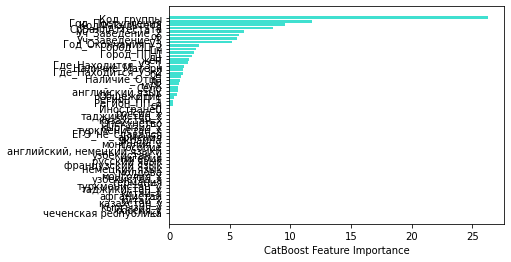

In [126]:
plt.barh(X_train.columns[sorted_feature_importance],
        model_list[0].feature_importances_[sorted_feature_importance], 
        color='turquoise')
plt.xlabel("CatBoost Feature Importance")

In [127]:
impotent_features = pd.DataFrame(index=X_train.columns[sorted_feature_importance], data=model_list[0].feature_importances_[sorted_feature_importance]).sort_values(by=0, ascending=False)
impotent_features

,0
Код_группы,26.307486
Год_Поступления,11.789837
КодФакультета,9.515708
СрБаллАттестата,8.540771
Уч_Заведение_2,6.194579
оо,5.788425
Уч_Заведение_1,5.631015
Год_Окончания_УЗ,5.214492
Город_ПП_2,2.470603
цн,2.222454


In [128]:
usless_features = impotent_features[impotent_features[0] == 0].index

In [133]:
usless_features

Index(['россия_y', 'монголия_x', 'кыргызия_y', 'казахстан_y', 'китай_x',
       'афганистан', 'китай_y', 'таджикистан_y', 'туркменистан_y', 'германия',
       'узбекистан_x', 'французский язык', 'молдова', 'немецкий язык',
       'русский язык', 'нигерия', 'узбекистан_y', 'английский, немецкий языки',
       'Пособие', 'монголия_y', 'украина', 'армения', 'чеченская республика'],
      dtype='object')

In [142]:
# дополнительно уберём бесполезные значения
X_train = train.drop(columns=usless_features)
X_train = X_train.drop(columns='Статус')
X_test = test.drop(columns=usless_features)
X_test = X_test.drop(columns='Статус')

In [143]:
print(X_train.columns)
#print(y_train.columns)
print(X_test.columns)
#print(y_test.columns)

Index(['Код_группы', 'Год_Поступления', 'Дата_Рождения', 'Год_Окончания_УЗ',
       'Общежитие', 'Наличие_Матери', 'Наличие_Отца', 'Опекунство', 'Село',
       'Иностранец', 'КодФакультета', 'СрБаллАттестата', 'ЕГЭ_не_сдавался',
       'Где_Находится_УЗ_1', 'Где_Находится_УЗ_2', 'Уч_Заведение_1',
       'Уч_Заведение_2', 'Регион_ПП_1', 'Регион_ПП_2', 'Город_ПП_1',
       'Город_ПП_2', 'оо', 'цн', 'дн', 'бн', 'сн', 'лн', 'жен', 'муж',
       'английский язык', 'россия_x', 'казахстан_x', 'кыргызия_x',
       'таджикистан_x', 'туркменистан_x'],
      dtype='object')
Index(['Код_группы', 'Год_Поступления', 'Дата_Рождения', 'Год_Окончания_УЗ',
       'Общежитие', 'Наличие_Матери', 'Наличие_Отца', 'Опекунство', 'Село',
       'Иностранец', 'КодФакультета', 'СрБаллАттестата', 'ЕГЭ_не_сдавался',
       'Где_Находится_УЗ_1', 'Где_Находится_УЗ_2', 'Уч_Заведение_1',
       'Уч_Заведение_2', 'Регион_ПП_1', 'Регион_ПП_2', 'Город_ПП_1',
       'Город_ПП_2', 'оо', 'цн', 'дн', 'бн', 'сн', 'лн', 'жен',

In [144]:
X_train_boost, X_valid_boost, y_train_boost, y_valid_boost = train_test_split(X_train, y_train, random_state=RANDOM_STATE, test_size=0.30)

In [145]:
print(X_train_boost.shape)
print(X_valid_boost.shape)
print(y_train_boost.shape)
print(y_valid_boost.shape)

(9508, 35)
(4076, 35)
(9508,)
(4076,)


In [149]:
def objective_cat(trial, X_train, X_test, y_train, y_test):
    param = {
         "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.03),
         "max_depth": trial.suggest_int('max_depth', 3, 15),
         "l2_leaf_reg": trial.suggest_discrete_uniform('l2_leaf_reg', 1.0, 5.5, 0.5),
         "min_child_samples": trial.suggest_categorical('min_child_samples', [1, 4, 8, 16, 32]),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"])
             
    }
    
    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    model = CatBoostClassifier(**param, random_seed=RANDOM_STATE)
    
    model.fit(X_train,
                  y_train,
                  eval_set=[(X_test, y_test)],
                  early_stopping_rounds=100,
                  use_best_model=True,
                  verbose=2)
    preds = model.predict(X_test)        
    score = f1_score(y_test, preds, average='macro', zero_division=0)   
    
    
    
    return score

In [150]:
study_cat = optuna.create_study(direction="maximize", study_name="CatBoostClassifier")
func_cat = lambda trial: objective_cat(trial, X_train_boost, X_valid_boost, y_train_boost, y_valid_boost)

study_cat.optimize(func_cat, n_trials=5, show_progress_bar=True)

[I 2022-09-12 20:21:39,293] A new study created in memory with name: CatBoostClassifier
C:\Users\Denis\AppData\Roaming\Python\Python38\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/5 [00:00<?, ?it/s]

0:	learn: 1.0839122	test: 1.0842206	best: 1.0842206 (0)	total: 497ms	remaining: 8m 16s
2:	learn: 1.0523095	test: 1.0527874	best: 1.0527874 (2)	total: 1.69s	remaining: 9m 21s
4:	learn: 1.0227177	test: 1.0234079	best: 1.0234079 (4)	total: 2.82s	remaining: 9m 20s
6:	learn: 0.9950201	test: 0.9959706	best: 0.9959706 (6)	total: 3.89s	remaining: 9m 12s
8:	learn: 0.9698494	test: 0.9713710	best: 0.9713710 (8)	total: 5.12s	remaining: 9m 24s
10:	learn: 0.9454976	test: 0.9469771	best: 0.9469771 (10)	total: 6.24s	remaining: 9m 20s
12:	learn: 0.9237442	test: 0.9252650	best: 0.9252650 (12)	total: 6.91s	remaining: 8m 44s
14:	learn: 0.9034523	test: 0.9048591	best: 0.9048591 (14)	total: 7.51s	remaining: 8m 13s
16:	learn: 0.8846429	test: 0.8860514	best: 0.8860514 (16)	total: 8.26s	remaining: 7m 57s
18:	learn: 0.8655177	test: 0.8673874	best: 0.8673874 (18)	total: 9.33s	remaining: 8m 1s
20:	learn: 0.8461182	test: 0.8480906	best: 0.8480906 (20)	total: 10.4s	remaining: 8m 6s
22:	learn: 0.8289777	test: 0.8308

184:	learn: 0.3888598	test: 0.4155237	best: 0.4155237 (184)	total: 1m 34s	remaining: 6m 57s
186:	learn: 0.3873185	test: 0.4145751	best: 0.4145751 (186)	total: 1m 35s	remaining: 6m 56s
188:	learn: 0.3860531	test: 0.4137487	best: 0.4137487 (188)	total: 1m 36s	remaining: 6m 55s
190:	learn: 0.3845551	test: 0.4128810	best: 0.4128810 (190)	total: 1m 37s	remaining: 6m 54s
192:	learn: 0.3829733	test: 0.4115284	best: 0.4115284 (192)	total: 1m 38s	remaining: 6m 53s
194:	learn: 0.3813631	test: 0.4103866	best: 0.4103866 (194)	total: 1m 40s	remaining: 6m 53s
196:	learn: 0.3799305	test: 0.4092396	best: 0.4092396 (196)	total: 1m 41s	remaining: 6m 52s
198:	learn: 0.3784207	test: 0.4085567	best: 0.4085567 (198)	total: 1m 42s	remaining: 6m 51s
200:	learn: 0.3770274	test: 0.4076948	best: 0.4076948 (200)	total: 1m 43s	remaining: 6m 51s
202:	learn: 0.3756358	test: 0.4068135	best: 0.4068135 (202)	total: 1m 45s	remaining: 6m 53s
204:	learn: 0.3742851	test: 0.4056499	best: 0.4056499 (204)	total: 1m 46s	remain

364:	learn: 0.2999085	test: 0.3663047	best: 0.3663047 (364)	total: 3m 11s	remaining: 5m 33s
366:	learn: 0.2992556	test: 0.3661319	best: 0.3661319 (366)	total: 3m 12s	remaining: 5m 32s
368:	learn: 0.2986678	test: 0.3658808	best: 0.3658808 (368)	total: 3m 13s	remaining: 5m 31s
370:	learn: 0.2980648	test: 0.3656631	best: 0.3656631 (370)	total: 3m 15s	remaining: 5m 30s
372:	learn: 0.2975784	test: 0.3654172	best: 0.3654172 (372)	total: 3m 16s	remaining: 5m 30s
374:	learn: 0.2970547	test: 0.3651053	best: 0.3651053 (374)	total: 3m 18s	remaining: 5m 30s
376:	learn: 0.2962509	test: 0.3648611	best: 0.3648611 (376)	total: 3m 19s	remaining: 5m 30s
378:	learn: 0.2955434	test: 0.3644692	best: 0.3644692 (378)	total: 3m 21s	remaining: 5m 29s
380:	learn: 0.2949398	test: 0.3641720	best: 0.3641720 (380)	total: 3m 22s	remaining: 5m 29s
382:	learn: 0.2943287	test: 0.3639852	best: 0.3639852 (382)	total: 3m 23s	remaining: 5m 28s
384:	learn: 0.2936518	test: 0.3637411	best: 0.3637411 (384)	total: 3m 25s	remain

544:	learn: 0.2513358	test: 0.3506061	best: 0.3506061 (544)	total: 4m 54s	remaining: 4m 5s
546:	learn: 0.2509287	test: 0.3504862	best: 0.3504862 (546)	total: 4m 55s	remaining: 4m 4s
548:	learn: 0.2504735	test: 0.3502841	best: 0.3502841 (548)	total: 4m 56s	remaining: 4m 3s
550:	learn: 0.2501102	test: 0.3501957	best: 0.3501957 (550)	total: 4m 57s	remaining: 4m 2s
552:	learn: 0.2497334	test: 0.3499883	best: 0.3499883 (552)	total: 4m 58s	remaining: 4m 1s
554:	learn: 0.2492669	test: 0.3497573	best: 0.3497573 (554)	total: 4m 59s	remaining: 3m 59s
556:	learn: 0.2488286	test: 0.3497437	best: 0.3497353 (555)	total: 5m	remaining: 3m 58s
558:	learn: 0.2485056	test: 0.3496810	best: 0.3496810 (558)	total: 5m 1s	remaining: 3m 57s
560:	learn: 0.2481513	test: 0.3495967	best: 0.3495967 (560)	total: 5m 2s	remaining: 3m 56s
562:	learn: 0.2477043	test: 0.3494725	best: 0.3494725 (562)	total: 5m 3s	remaining: 3m 55s
564:	learn: 0.2473171	test: 0.3493468	best: 0.3493468 (564)	total: 5m 4s	remaining: 3m 54s
5

724:	learn: 0.2161090	test: 0.3399931	best: 0.3399931 (724)	total: 6m 22s	remaining: 2m 24s
726:	learn: 0.2158112	test: 0.3400033	best: 0.3399927 (725)	total: 6m 23s	remaining: 2m 23s
728:	learn: 0.2154355	test: 0.3397898	best: 0.3397898 (728)	total: 6m 24s	remaining: 2m 22s
730:	learn: 0.2150583	test: 0.3397271	best: 0.3397271 (730)	total: 6m 25s	remaining: 2m 21s
732:	learn: 0.2147040	test: 0.3395749	best: 0.3395749 (732)	total: 6m 26s	remaining: 2m 20s
734:	learn: 0.2143766	test: 0.3395990	best: 0.3395749 (732)	total: 6m 27s	remaining: 2m 19s
736:	learn: 0.2140442	test: 0.3395110	best: 0.3395110 (736)	total: 6m 28s	remaining: 2m 18s
738:	learn: 0.2136972	test: 0.3394715	best: 0.3394715 (738)	total: 6m 29s	remaining: 2m 17s
740:	learn: 0.2133172	test: 0.3394425	best: 0.3394382 (739)	total: 6m 29s	remaining: 2m 16s
742:	learn: 0.2130145	test: 0.3394301	best: 0.3394121 (741)	total: 6m 30s	remaining: 2m 15s
744:	learn: 0.2127878	test: 0.3393596	best: 0.3393596 (744)	total: 6m 31s	remain

904:	learn: 0.1892350	test: 0.3345274	best: 0.3345274 (904)	total: 7m 48s	remaining: 49.2s
906:	learn: 0.1889207	test: 0.3344192	best: 0.3344192 (906)	total: 7m 49s	remaining: 48.2s
908:	learn: 0.1886609	test: 0.3342942	best: 0.3342942 (908)	total: 7m 50s	remaining: 47.1s
910:	learn: 0.1884420	test: 0.3342730	best: 0.3342559 (909)	total: 7m 51s	remaining: 46.1s
912:	learn: 0.1881350	test: 0.3340654	best: 0.3340654 (912)	total: 7m 52s	remaining: 45s
914:	learn: 0.1878577	test: 0.3340966	best: 0.3340584 (913)	total: 7m 53s	remaining: 44s
916:	learn: 0.1876509	test: 0.3340247	best: 0.3340247 (916)	total: 7m 54s	remaining: 42.9s
918:	learn: 0.1874150	test: 0.3339563	best: 0.3339563 (918)	total: 7m 55s	remaining: 41.9s
920:	learn: 0.1871924	test: 0.3337870	best: 0.3337870 (920)	total: 7m 56s	remaining: 40.9s
922:	learn: 0.1869452	test: 0.3338287	best: 0.3337870 (920)	total: 7m 57s	remaining: 39.8s
924:	learn: 0.1867385	test: 0.3337344	best: 0.3337344 (924)	total: 7m 58s	remaining: 38.8s
926

78:	learn: 1.0101082	test: 1.0108451	best: 1.0108451 (78)	total: 37.6s	remaining: 7m 18s
80:	learn: 1.0080186	test: 1.0087861	best: 1.0087861 (80)	total: 38.8s	remaining: 7m 20s
82:	learn: 1.0059369	test: 1.0067259	best: 1.0067259 (82)	total: 40.1s	remaining: 7m 23s
84:	learn: 1.0039994	test: 1.0047996	best: 1.0047996 (84)	total: 41.4s	remaining: 7m 25s
86:	learn: 1.0019603	test: 1.0027813	best: 1.0027813 (86)	total: 42.5s	remaining: 7m 26s
88:	learn: 0.9999780	test: 1.0007856	best: 1.0007856 (88)	total: 43.2s	remaining: 7m 22s
90:	learn: 0.9980088	test: 0.9988827	best: 0.9988827 (90)	total: 44.2s	remaining: 7m 21s
92:	learn: 0.9960997	test: 0.9970282	best: 0.9970282 (92)	total: 45.3s	remaining: 7m 21s
94:	learn: 0.9941482	test: 0.9951008	best: 0.9951008 (94)	total: 46.4s	remaining: 7m 22s
96:	learn: 0.9921658	test: 0.9931597	best: 0.9931597 (96)	total: 47.6s	remaining: 7m 22s
98:	learn: 0.9902188	test: 0.9912516	best: 0.9912516 (98)	total: 48.6s	remaining: 7m 22s
100:	learn: 0.9883101

258:	learn: 0.8578222	test: 0.8607293	best: 0.8607293 (258)	total: 2m 24s	remaining: 6m 54s
260:	learn: 0.8564898	test: 0.8593972	best: 0.8593972 (260)	total: 2m 25s	remaining: 6m 52s
262:	learn: 0.8550476	test: 0.8579781	best: 0.8579781 (262)	total: 2m 26s	remaining: 6m 51s
264:	learn: 0.8536248	test: 0.8565794	best: 0.8565794 (264)	total: 2m 27s	remaining: 6m 49s
266:	learn: 0.8522028	test: 0.8551896	best: 0.8551896 (266)	total: 2m 28s	remaining: 6m 48s
268:	learn: 0.8508143	test: 0.8538071	best: 0.8538071 (268)	total: 2m 29s	remaining: 6m 46s
270:	learn: 0.8494274	test: 0.8524563	best: 0.8524563 (270)	total: 2m 30s	remaining: 6m 45s
272:	learn: 0.8480639	test: 0.8511316	best: 0.8511316 (272)	total: 2m 31s	remaining: 6m 44s
274:	learn: 0.8466734	test: 0.8497587	best: 0.8497587 (274)	total: 2m 32s	remaining: 6m 42s
276:	learn: 0.8453079	test: 0.8484123	best: 0.8484123 (276)	total: 2m 33s	remaining: 6m 41s
278:	learn: 0.8439280	test: 0.8470382	best: 0.8470382 (278)	total: 2m 34s	remain

438:	learn: 0.7492634	test: 0.7540520	best: 0.7540520 (438)	total: 3m 52s	remaining: 4m 57s
440:	learn: 0.7482476	test: 0.7530428	best: 0.7530428 (440)	total: 3m 53s	remaining: 4m 56s
442:	learn: 0.7471926	test: 0.7519875	best: 0.7519875 (442)	total: 3m 54s	remaining: 4m 55s
444:	learn: 0.7461501	test: 0.7509655	best: 0.7509655 (444)	total: 3m 55s	remaining: 4m 54s
446:	learn: 0.7451679	test: 0.7500094	best: 0.7500094 (446)	total: 3m 56s	remaining: 4m 53s
448:	learn: 0.7441575	test: 0.7490365	best: 0.7490365 (448)	total: 3m 57s	remaining: 4m 52s
450:	learn: 0.7431432	test: 0.7480502	best: 0.7480502 (450)	total: 3m 58s	remaining: 4m 50s
452:	learn: 0.7421326	test: 0.7470397	best: 0.7470397 (452)	total: 3m 59s	remaining: 4m 49s
454:	learn: 0.7411209	test: 0.7460499	best: 0.7460499 (454)	total: 4m	remaining: 4m 48s
456:	learn: 0.7401173	test: 0.7450728	best: 0.7450728 (456)	total: 4m 1s	remaining: 4m 47s
458:	learn: 0.7391204	test: 0.7440881	best: 0.7440881 (458)	total: 4m 2s	remaining: 4

618:	learn: 0.6681840	test: 0.6748054	best: 0.6748054 (618)	total: 5m 19s	remaining: 3m 16s
620:	learn: 0.6674364	test: 0.6740900	best: 0.6740900 (620)	total: 5m 20s	remaining: 3m 15s
622:	learn: 0.6666762	test: 0.6733554	best: 0.6733554 (622)	total: 5m 21s	remaining: 3m 14s
624:	learn: 0.6659058	test: 0.6726035	best: 0.6726035 (624)	total: 5m 22s	remaining: 3m 13s
626:	learn: 0.6650842	test: 0.6718023	best: 0.6718023 (626)	total: 5m 23s	remaining: 3m 12s
628:	learn: 0.6642525	test: 0.6709906	best: 0.6709906 (628)	total: 5m 24s	remaining: 3m 11s
630:	learn: 0.6634646	test: 0.6702151	best: 0.6702151 (630)	total: 5m 25s	remaining: 3m 10s
632:	learn: 0.6626874	test: 0.6694418	best: 0.6694418 (632)	total: 5m 26s	remaining: 3m 9s
634:	learn: 0.6619184	test: 0.6686771	best: 0.6686771 (634)	total: 5m 27s	remaining: 3m 8s
636:	learn: 0.6611383	test: 0.6679187	best: 0.6679187 (636)	total: 5m 28s	remaining: 3m 7s
638:	learn: 0.6603522	test: 0.6671596	best: 0.6671596 (638)	total: 5m 29s	remaining

798:	learn: 0.6069215	test: 0.6154427	best: 0.6154427 (798)	total: 6m 48s	remaining: 1m 42s
800:	learn: 0.6062913	test: 0.6148415	best: 0.6148415 (800)	total: 6m 49s	remaining: 1m 41s
802:	learn: 0.6057170	test: 0.6142967	best: 0.6142967 (802)	total: 6m 50s	remaining: 1m 40s
804:	learn: 0.6051242	test: 0.6137299	best: 0.6137299 (804)	total: 6m 51s	remaining: 1m 39s
806:	learn: 0.6044813	test: 0.6131208	best: 0.6131208 (806)	total: 6m 52s	remaining: 1m 38s
808:	learn: 0.6039066	test: 0.6125855	best: 0.6125855 (808)	total: 6m 53s	remaining: 1m 37s
810:	learn: 0.6033140	test: 0.6120246	best: 0.6120246 (810)	total: 6m 54s	remaining: 1m 36s
812:	learn: 0.6026683	test: 0.6113973	best: 0.6113973 (812)	total: 6m 55s	remaining: 1m 35s
814:	learn: 0.6021301	test: 0.6108935	best: 0.6108935 (814)	total: 6m 56s	remaining: 1m 34s
816:	learn: 0.6014859	test: 0.6102804	best: 0.6102804 (816)	total: 6m 57s	remaining: 1m 33s
818:	learn: 0.6008661	test: 0.6096919	best: 0.6096919 (818)	total: 6m 58s	remain

980:	learn: 0.5582944	test: 0.5690189	best: 0.5690189 (980)	total: 8m 19s	remaining: 9.68s
982:	learn: 0.5578177	test: 0.5685577	best: 0.5685577 (982)	total: 8m 20s	remaining: 8.66s
984:	learn: 0.5573860	test: 0.5681801	best: 0.5681801 (984)	total: 8m 21s	remaining: 7.64s
986:	learn: 0.5569678	test: 0.5677692	best: 0.5677692 (986)	total: 8m 22s	remaining: 6.62s
988:	learn: 0.5565383	test: 0.5673793	best: 0.5673793 (988)	total: 8m 23s	remaining: 5.6s
990:	learn: 0.5560282	test: 0.5668856	best: 0.5668856 (990)	total: 8m 24s	remaining: 4.58s
992:	learn: 0.5555800	test: 0.5664660	best: 0.5664660 (992)	total: 8m 25s	remaining: 3.56s
994:	learn: 0.5551121	test: 0.5660331	best: 0.5660331 (994)	total: 8m 26s	remaining: 2.54s
996:	learn: 0.5545849	test: 0.5655298	best: 0.5655298 (996)	total: 8m 27s	remaining: 1.53s
998:	learn: 0.5541001	test: 0.5650592	best: 0.5650592 (998)	total: 8m 28s	remaining: 509ms
999:	learn: 0.5538681	test: 0.5648427	best: 0.5648427 (999)	total: 8m 29s	remaining: 0us

b

170:	learn: 0.7414438	test: 0.7318845	best: 0.7318845 (170)	total: 1.04s	remaining: 5.04s
172:	learn: 0.7393325	test: 0.7297120	best: 0.7297120 (172)	total: 1.05s	remaining: 5.02s
174:	learn: 0.7371264	test: 0.7274236	best: 0.7274236 (174)	total: 1.06s	remaining: 5.01s
176:	learn: 0.7349693	test: 0.7252312	best: 0.7252312 (176)	total: 1.07s	remaining: 4.99s
178:	learn: 0.7331097	test: 0.7233212	best: 0.7233212 (178)	total: 1.08s	remaining: 4.98s
180:	learn: 0.7310379	test: 0.7212433	best: 0.7212433 (180)	total: 1.1s	remaining: 4.96s
182:	learn: 0.7290837	test: 0.7192966	best: 0.7192966 (182)	total: 1.11s	remaining: 4.95s
184:	learn: 0.7271237	test: 0.7173394	best: 0.7173394 (184)	total: 1.12s	remaining: 4.94s
186:	learn: 0.7250853	test: 0.7151905	best: 0.7151905 (186)	total: 1.13s	remaining: 4.92s
188:	learn: 0.7232756	test: 0.7133164	best: 0.7133164 (188)	total: 1.15s	remaining: 4.92s
190:	learn: 0.7215043	test: 0.7114942	best: 0.7114942 (190)	total: 1.16s	remaining: 4.9s
192:	learn: 

360:	learn: 0.6135192	test: 0.6004728	best: 0.6004728 (360)	total: 2.17s	remaining: 3.84s
362:	learn: 0.6125136	test: 0.5994356	best: 0.5994356 (362)	total: 2.18s	remaining: 3.82s
364:	learn: 0.6118693	test: 0.5988009	best: 0.5988009 (364)	total: 2.19s	remaining: 3.81s
366:	learn: 0.6112689	test: 0.5981822	best: 0.5981822 (366)	total: 2.2s	remaining: 3.8s
368:	learn: 0.6101750	test: 0.5970649	best: 0.5970649 (368)	total: 2.21s	remaining: 3.79s
370:	learn: 0.6093530	test: 0.5962309	best: 0.5962309 (370)	total: 2.23s	remaining: 3.77s
372:	learn: 0.6087865	test: 0.5956328	best: 0.5956328 (372)	total: 2.24s	remaining: 3.76s
374:	learn: 0.6078626	test: 0.5946959	best: 0.5946959 (374)	total: 2.25s	remaining: 3.75s
376:	learn: 0.6069406	test: 0.5937029	best: 0.5937029 (376)	total: 2.26s	remaining: 3.74s
378:	learn: 0.6062231	test: 0.5929624	best: 0.5929624 (378)	total: 2.27s	remaining: 3.73s
380:	learn: 0.6053863	test: 0.5921290	best: 0.5921290 (380)	total: 2.29s	remaining: 3.71s
382:	learn: 

558:	learn: 0.5549582	test: 0.5408311	best: 0.5408311 (558)	total: 3.32s	remaining: 2.62s
560:	learn: 0.5543325	test: 0.5401978	best: 0.5401978 (560)	total: 3.33s	remaining: 2.6s
562:	learn: 0.5539490	test: 0.5398218	best: 0.5398218 (562)	total: 3.34s	remaining: 2.59s
564:	learn: 0.5536619	test: 0.5395309	best: 0.5395309 (564)	total: 3.35s	remaining: 2.58s
566:	learn: 0.5533579	test: 0.5392040	best: 0.5392040 (566)	total: 3.36s	remaining: 2.57s
568:	learn: 0.5531031	test: 0.5389267	best: 0.5389267 (568)	total: 3.37s	remaining: 2.55s
570:	learn: 0.5526892	test: 0.5385200	best: 0.5385200 (570)	total: 3.38s	remaining: 2.54s
572:	learn: 0.5524139	test: 0.5382454	best: 0.5382454 (572)	total: 3.39s	remaining: 2.53s
574:	learn: 0.5521898	test: 0.5380144	best: 0.5380144 (574)	total: 3.4s	remaining: 2.51s
576:	learn: 0.5516634	test: 0.5374996	best: 0.5374996 (576)	total: 3.42s	remaining: 2.5s
578:	learn: 0.5512801	test: 0.5371058	best: 0.5371058 (578)	total: 3.43s	remaining: 2.49s
580:	learn: 0

760:	learn: 0.5234134	test: 0.5091949	best: 0.5091949 (760)	total: 4.48s	remaining: 1.41s
762:	learn: 0.5230918	test: 0.5088802	best: 0.5088802 (762)	total: 4.49s	remaining: 1.39s
764:	learn: 0.5228904	test: 0.5086898	best: 0.5086898 (764)	total: 4.5s	remaining: 1.38s
766:	learn: 0.5226214	test: 0.5084105	best: 0.5084105 (766)	total: 4.51s	remaining: 1.37s
768:	learn: 0.5222667	test: 0.5080604	best: 0.5080604 (768)	total: 4.52s	remaining: 1.36s
770:	learn: 0.5217920	test: 0.5075819	best: 0.5075819 (770)	total: 4.53s	remaining: 1.35s
772:	learn: 0.5215512	test: 0.5073584	best: 0.5073584 (772)	total: 4.54s	remaining: 1.33s
774:	learn: 0.5210951	test: 0.5069081	best: 0.5069081 (774)	total: 4.56s	remaining: 1.32s
776:	learn: 0.5209967	test: 0.5068211	best: 0.5068211 (776)	total: 4.57s	remaining: 1.31s
778:	learn: 0.5207932	test: 0.5066321	best: 0.5066321 (778)	total: 4.58s	remaining: 1.3s
780:	learn: 0.5205196	test: 0.5063800	best: 0.5063800 (780)	total: 4.59s	remaining: 1.29s
782:	learn: 

964:	learn: 0.5004037	test: 0.4869120	best: 0.4869120 (964)	total: 5.66s	remaining: 205ms
966:	learn: 0.5002514	test: 0.4867564	best: 0.4867564 (966)	total: 5.67s	remaining: 194ms
968:	learn: 0.5001435	test: 0.4866573	best: 0.4866573 (968)	total: 5.68s	remaining: 182ms
970:	learn: 0.4998919	test: 0.4864082	best: 0.4864082 (970)	total: 5.7s	remaining: 170ms
972:	learn: 0.4997453	test: 0.4862721	best: 0.4862721 (972)	total: 5.71s	remaining: 158ms
974:	learn: 0.4995821	test: 0.4861230	best: 0.4861230 (974)	total: 5.72s	remaining: 147ms
976:	learn: 0.4994890	test: 0.4860324	best: 0.4860324 (976)	total: 5.74s	remaining: 135ms
978:	learn: 0.4992970	test: 0.4858810	best: 0.4858810 (978)	total: 5.75s	remaining: 123ms
980:	learn: 0.4990937	test: 0.4857019	best: 0.4857019 (980)	total: 5.76s	remaining: 111ms
982:	learn: 0.4989066	test: 0.4855202	best: 0.4855202 (982)	total: 5.77s	remaining: 99.7ms
984:	learn: 0.4986776	test: 0.4852814	best: 0.4852814 (984)	total: 5.78s	remaining: 88ms
986:	learn:

140:	learn: 0.6046889	test: 0.5915808	best: 0.5915808 (140)	total: 4.86s	remaining: 29.6s
142:	learn: 0.6021512	test: 0.5891409	best: 0.5891409 (142)	total: 4.94s	remaining: 29.6s
144:	learn: 0.6014150	test: 0.5883035	best: 0.5883035 (144)	total: 5.01s	remaining: 29.5s
146:	learn: 0.5997523	test: 0.5866131	best: 0.5866131 (146)	total: 5.08s	remaining: 29.5s
148:	learn: 0.5970562	test: 0.5839177	best: 0.5839177 (148)	total: 5.14s	remaining: 29.4s
150:	learn: 0.5954888	test: 0.5823164	best: 0.5823164 (150)	total: 5.22s	remaining: 29.4s
152:	learn: 0.5946213	test: 0.5814239	best: 0.5814239 (152)	total: 5.28s	remaining: 29.2s
154:	learn: 0.5939368	test: 0.5806258	best: 0.5806258 (154)	total: 5.34s	remaining: 29.1s
156:	learn: 0.5925571	test: 0.5791816	best: 0.5791816 (156)	total: 5.41s	remaining: 29.1s
158:	learn: 0.5907338	test: 0.5773338	best: 0.5773338 (158)	total: 5.49s	remaining: 29.1s
160:	learn: 0.5896754	test: 0.5762694	best: 0.5762694 (160)	total: 5.56s	remaining: 29s
162:	learn: 

326:	learn: 0.5350966	test: 0.5237794	best: 0.5237794 (326)	total: 11.3s	remaining: 23.2s
328:	learn: 0.5345057	test: 0.5232428	best: 0.5232428 (328)	total: 11.3s	remaining: 23.1s
330:	learn: 0.5343578	test: 0.5230912	best: 0.5230912 (330)	total: 11.4s	remaining: 23s
332:	learn: 0.5339388	test: 0.5227139	best: 0.5227139 (332)	total: 11.5s	remaining: 23s
334:	learn: 0.5334901	test: 0.5222863	best: 0.5222863 (334)	total: 11.5s	remaining: 22.9s
336:	learn: 0.5330975	test: 0.5219248	best: 0.5219248 (336)	total: 11.6s	remaining: 22.8s
338:	learn: 0.5327026	test: 0.5215984	best: 0.5215984 (338)	total: 11.6s	remaining: 22.7s
340:	learn: 0.5325456	test: 0.5214613	best: 0.5214613 (340)	total: 11.7s	remaining: 22.6s
342:	learn: 0.5319700	test: 0.5209546	best: 0.5209546 (342)	total: 11.8s	remaining: 22.6s
344:	learn: 0.5316996	test: 0.5206928	best: 0.5206928 (344)	total: 11.9s	remaining: 22.5s
346:	learn: 0.5313345	test: 0.5203832	best: 0.5203832 (346)	total: 11.9s	remaining: 22.5s
348:	learn: 0.

510:	learn: 0.5097469	test: 0.5011917	best: 0.5011917 (510)	total: 17.6s	remaining: 16.8s
512:	learn: 0.5095230	test: 0.5010012	best: 0.5010012 (512)	total: 17.7s	remaining: 16.8s
514:	learn: 0.5093641	test: 0.5008809	best: 0.5008809 (514)	total: 17.7s	remaining: 16.7s
516:	learn: 0.5092615	test: 0.5008059	best: 0.5008059 (516)	total: 17.8s	remaining: 16.6s
518:	learn: 0.5088729	test: 0.5004619	best: 0.5004619 (518)	total: 17.9s	remaining: 16.6s
520:	learn: 0.5087952	test: 0.5003961	best: 0.5003961 (520)	total: 18s	remaining: 16.5s
522:	learn: 0.5086036	test: 0.5002380	best: 0.5002380 (522)	total: 18s	remaining: 16.5s
524:	learn: 0.5083462	test: 0.5000188	best: 0.5000188 (524)	total: 18.1s	remaining: 16.4s
526:	learn: 0.5081503	test: 0.4998522	best: 0.4998522 (526)	total: 18.2s	remaining: 16.3s
528:	learn: 0.5080106	test: 0.4997322	best: 0.4997322 (528)	total: 18.2s	remaining: 16.2s
530:	learn: 0.5079166	test: 0.4996690	best: 0.4996690 (530)	total: 18.3s	remaining: 16.2s
532:	learn: 0.

698:	learn: 0.4912220	test: 0.4856527	best: 0.4856527 (698)	total: 24.1s	remaining: 10.4s
700:	learn: 0.4911227	test: 0.4856032	best: 0.4856032 (700)	total: 24.2s	remaining: 10.3s
702:	learn: 0.4908779	test: 0.4854138	best: 0.4854138 (702)	total: 24.3s	remaining: 10.3s
704:	learn: 0.4908254	test: 0.4854109	best: 0.4854075 (703)	total: 24.4s	remaining: 10.2s
706:	learn: 0.4907790	test: 0.4854022	best: 0.4854022 (706)	total: 24.4s	remaining: 10.1s
708:	learn: 0.4906731	test: 0.4853689	best: 0.4853689 (708)	total: 24.5s	remaining: 10s
710:	learn: 0.4906375	test: 0.4853300	best: 0.4853300 (710)	total: 24.6s	remaining: 9.98s
712:	learn: 0.4905872	test: 0.4852999	best: 0.4852999 (712)	total: 24.6s	remaining: 9.91s
714:	learn: 0.4904311	test: 0.4851730	best: 0.4851730 (714)	total: 24.7s	remaining: 9.84s
716:	learn: 0.4903950	test: 0.4851504	best: 0.4851504 (716)	total: 24.8s	remaining: 9.77s
718:	learn: 0.4901842	test: 0.4849395	best: 0.4849395 (718)	total: 24.8s	remaining: 9.7s
720:	learn: 0

884:	learn: 0.4744933	test: 0.4716557	best: 0.4716557 (884)	total: 30.6s	remaining: 3.98s
886:	learn: 0.4739139	test: 0.4710896	best: 0.4710896 (886)	total: 30.7s	remaining: 3.91s
888:	learn: 0.4738359	test: 0.4710491	best: 0.4710491 (888)	total: 30.7s	remaining: 3.84s
890:	learn: 0.4736730	test: 0.4709481	best: 0.4709389 (889)	total: 30.8s	remaining: 3.77s
892:	learn: 0.4735175	test: 0.4707951	best: 0.4707951 (892)	total: 30.9s	remaining: 3.7s
894:	learn: 0.4733194	test: 0.4706361	best: 0.4706361 (894)	total: 30.9s	remaining: 3.63s
896:	learn: 0.4732733	test: 0.4705860	best: 0.4705860 (896)	total: 31s	remaining: 3.56s
898:	learn: 0.4731798	test: 0.4704840	best: 0.4704840 (898)	total: 31.1s	remaining: 3.49s
900:	learn: 0.4730563	test: 0.4703815	best: 0.4703815 (900)	total: 31.1s	remaining: 3.42s
902:	learn: 0.4729544	test: 0.4703136	best: 0.4703136 (902)	total: 31.2s	remaining: 3.35s
904:	learn: 0.4728554	test: 0.4702712	best: 0.4702712 (904)	total: 31.3s	remaining: 3.28s
906:	learn: 0

58:	learn: 0.5894425	test: 0.5900695	best: 0.5900695 (58)	total: 4.41s	remaining: 1m 10s
60:	learn: 0.5829392	test: 0.5839744	best: 0.5839744 (60)	total: 4.56s	remaining: 1m 10s
62:	learn: 0.5764835	test: 0.5779255	best: 0.5779255 (62)	total: 4.71s	remaining: 1m 10s
64:	learn: 0.5693574	test: 0.5708248	best: 0.5708248 (64)	total: 4.85s	remaining: 1m 9s
66:	learn: 0.5641383	test: 0.5657602	best: 0.5657602 (66)	total: 5s	remaining: 1m 9s
68:	learn: 0.5586076	test: 0.5605088	best: 0.5605088 (68)	total: 5.16s	remaining: 1m 9s
70:	learn: 0.5540082	test: 0.5561945	best: 0.5561945 (70)	total: 5.31s	remaining: 1m 9s
72:	learn: 0.5487887	test: 0.5511974	best: 0.5511974 (72)	total: 5.46s	remaining: 1m 9s
74:	learn: 0.5439865	test: 0.5466991	best: 0.5466991 (74)	total: 5.62s	remaining: 1m 9s
76:	learn: 0.5388658	test: 0.5417616	best: 0.5417616 (76)	total: 5.75s	remaining: 1m 8s
78:	learn: 0.5339316	test: 0.5372166	best: 0.5372166 (78)	total: 5.94s	remaining: 1m 9s
80:	learn: 0.5301787	test: 0.533

242:	learn: 0.3806260	test: 0.4133298	best: 0.4133298 (242)	total: 18.3s	remaining: 57s
244:	learn: 0.3795194	test: 0.4125488	best: 0.4125488 (244)	total: 18.4s	remaining: 56.8s
246:	learn: 0.3789500	test: 0.4123343	best: 0.4123343 (246)	total: 18.6s	remaining: 56.7s
248:	learn: 0.3783616	test: 0.4120751	best: 0.4120751 (248)	total: 18.7s	remaining: 56.5s
250:	learn: 0.3777534	test: 0.4118183	best: 0.4118183 (250)	total: 18.9s	remaining: 56.3s
252:	learn: 0.3768720	test: 0.4115322	best: 0.4115322 (252)	total: 19s	remaining: 56.2s
254:	learn: 0.3761812	test: 0.4110689	best: 0.4110689 (254)	total: 19.2s	remaining: 56s
256:	learn: 0.3754103	test: 0.4108487	best: 0.4108487 (256)	total: 19.3s	remaining: 55.9s
258:	learn: 0.3746219	test: 0.4104524	best: 0.4104524 (258)	total: 19.5s	remaining: 55.8s
260:	learn: 0.3738401	test: 0.4099902	best: 0.4099902 (260)	total: 19.6s	remaining: 55.6s
262:	learn: 0.3727369	test: 0.4094081	best: 0.4094081 (262)	total: 19.8s	remaining: 55.5s
264:	learn: 0.37

428:	learn: 0.3211489	test: 0.3840824	best: 0.3840824 (428)	total: 35.4s	remaining: 47.1s
430:	learn: 0.3206733	test: 0.3838363	best: 0.3838363 (430)	total: 35.5s	remaining: 46.9s
432:	learn: 0.3201124	test: 0.3837109	best: 0.3837109 (432)	total: 35.7s	remaining: 46.7s
434:	learn: 0.3197482	test: 0.3836345	best: 0.3836345 (434)	total: 35.8s	remaining: 46.5s
436:	learn: 0.3193012	test: 0.3834102	best: 0.3834102 (436)	total: 36s	remaining: 46.3s
438:	learn: 0.3188797	test: 0.3832672	best: 0.3832672 (438)	total: 36.1s	remaining: 46.2s
440:	learn: 0.3182321	test: 0.3829372	best: 0.3829372 (440)	total: 36.3s	remaining: 46s
442:	learn: 0.3177726	test: 0.3826597	best: 0.3826597 (442)	total: 36.4s	remaining: 45.8s
444:	learn: 0.3171930	test: 0.3823257	best: 0.3823257 (444)	total: 36.6s	remaining: 45.6s
446:	learn: 0.3168020	test: 0.3822191	best: 0.3822191 (446)	total: 36.8s	remaining: 45.5s
448:	learn: 0.3164422	test: 0.3821271	best: 0.3821271 (448)	total: 36.9s	remaining: 45.3s
450:	learn: 0.

612:	learn: 0.2838114	test: 0.3725743	best: 0.3725743 (612)	total: 49.9s	remaining: 31.5s
614:	learn: 0.2835671	test: 0.3725449	best: 0.3725071 (613)	total: 50.1s	remaining: 31.4s
616:	learn: 0.2832812	test: 0.3724654	best: 0.3724654 (616)	total: 50.2s	remaining: 31.2s
618:	learn: 0.2829302	test: 0.3723036	best: 0.3723036 (618)	total: 50.4s	remaining: 31s
620:	learn: 0.2826409	test: 0.3722895	best: 0.3722813 (619)	total: 50.6s	remaining: 30.9s
622:	learn: 0.2823825	test: 0.3722435	best: 0.3722435 (622)	total: 50.7s	remaining: 30.7s
624:	learn: 0.2820981	test: 0.3721495	best: 0.3721495 (624)	total: 50.9s	remaining: 30.5s
626:	learn: 0.2817109	test: 0.3721299	best: 0.3721234 (625)	total: 51s	remaining: 30.3s
628:	learn: 0.2812813	test: 0.3720193	best: 0.3720193 (628)	total: 51.2s	remaining: 30.2s
630:	learn: 0.2808531	test: 0.3718119	best: 0.3718119 (630)	total: 51.3s	remaining: 30s
632:	learn: 0.2804147	test: 0.3716104	best: 0.3716104 (632)	total: 51.5s	remaining: 29.8s
634:	learn: 0.28

798:	learn: 0.2557505	test: 0.3664292	best: 0.3664292 (798)	total: 1m 4s	remaining: 16.2s
800:	learn: 0.2555882	test: 0.3663948	best: 0.3663948 (800)	total: 1m 4s	remaining: 16.1s
802:	learn: 0.2552765	test: 0.3662653	best: 0.3662653 (802)	total: 1m 4s	remaining: 15.9s
804:	learn: 0.2550677	test: 0.3662293	best: 0.3662293 (804)	total: 1m 4s	remaining: 15.7s
806:	learn: 0.2548774	test: 0.3662771	best: 0.3662293 (804)	total: 1m 5s	remaining: 15.6s
808:	learn: 0.2546035	test: 0.3662164	best: 0.3662164 (808)	total: 1m 5s	remaining: 15.4s
810:	learn: 0.2543403	test: 0.3661803	best: 0.3661803 (810)	total: 1m 5s	remaining: 15.2s
812:	learn: 0.2540648	test: 0.3661293	best: 0.3661293 (812)	total: 1m 5s	remaining: 15.1s
814:	learn: 0.2538243	test: 0.3662143	best: 0.3661293 (812)	total: 1m 5s	remaining: 14.9s
816:	learn: 0.2535419	test: 0.3661144	best: 0.3661144 (816)	total: 1m 5s	remaining: 14.8s
818:	learn: 0.2532804	test: 0.3660685	best: 0.3660685 (818)	total: 1m 6s	remaining: 14.6s
820:	learn

980:	learn: 0.2332549	test: 0.3623975	best: 0.3623975 (980)	total: 1m 18s	remaining: 1.52s
982:	learn: 0.2329895	test: 0.3624211	best: 0.3623822 (981)	total: 1m 18s	remaining: 1.36s
984:	learn: 0.2327969	test: 0.3624449	best: 0.3623822 (981)	total: 1m 18s	remaining: 1.2s
986:	learn: 0.2324556	test: 0.3623872	best: 0.3623822 (981)	total: 1m 19s	remaining: 1.04s
988:	learn: 0.2322947	test: 0.3623909	best: 0.3623794 (987)	total: 1m 19s	remaining: 881ms
990:	learn: 0.2319660	test: 0.3622938	best: 0.3622938 (990)	total: 1m 19s	remaining: 721ms
992:	learn: 0.2317604	test: 0.3622056	best: 0.3622056 (992)	total: 1m 19s	remaining: 560ms
994:	learn: 0.2315744	test: 0.3622416	best: 0.3622056 (992)	total: 1m 19s	remaining: 400ms
996:	learn: 0.2313102	test: 0.3622116	best: 0.3622056 (992)	total: 1m 19s	remaining: 240ms
998:	learn: 0.2310601	test: 0.3621530	best: 0.3621530 (998)	total: 1m 19s	remaining: 80ms
999:	learn: 0.2309488	test: 0.3622013	best: 0.3621530 (998)	total: 1m 20s	remaining: 0us

be

In [151]:
print(f"\tBest value (F1): {study_cat.best_value:.5f}")
print(f"\tBest params:")

for key, value in study_cat.best_params.items():
    print(f"\t\t{key}: {value}")


	Best value (F1): 0.74336
	Best params:
		learning_rate: 0.01563405145889339
		max_depth: 12
		l2_leaf_reg: 2.5
		min_child_samples: 32
		boosting_type: Plain
		bootstrap_type: MVS


	Best value (F1): 0.74539
	Best params:
		learning_rate: 0.02548590924207488
		max_depth: 8
		l2_leaf_reg: 5.5
		min_child_samples: 32

In [152]:
#from optuna.visualization.matplotlib import plot_param_importances

#plot_param_importances(study_cat);

In [153]:
model_test = CatBoostClassifier(**study_cat.best_params, random_seed=RANDOM_STATE)
model_test.fit(X_train,
                  y_train,
                  early_stopping_rounds=100,
                  use_best_model=True
                  )
preds = model_test.predict(X_test)        
#score = f1_score(y_test, preds, average='macro', zero_division=0)  

#print(f'Резултьтат F1 на тестовой выборке:{score}')

You should provide test set for use best model. use_best_model parameter has been switched to false value.


0:	learn: 1.0820221	total: 505ms	remaining: 8m 24s
1:	learn: 1.0667126	total: 1.01s	remaining: 8m 25s
2:	learn: 1.0502119	total: 1.53s	remaining: 8m 28s
3:	learn: 1.0346258	total: 2.01s	remaining: 8m 21s
4:	learn: 1.0201882	total: 2.54s	remaining: 8m 24s
5:	learn: 1.0057879	total: 3.08s	remaining: 8m 30s
6:	learn: 0.9916102	total: 3.58s	remaining: 8m 27s
7:	learn: 0.9774389	total: 4.12s	remaining: 8m 30s
8:	learn: 0.9654859	total: 4.64s	remaining: 8m 30s
9:	learn: 0.9524475	total: 5.14s	remaining: 8m 28s
10:	learn: 0.9403562	total: 5.67s	remaining: 8m 29s
11:	learn: 0.9286000	total: 6.2s	remaining: 8m 30s
12:	learn: 0.9175288	total: 6.27s	remaining: 7m 56s
13:	learn: 0.9072088	total: 6.31s	remaining: 7m 24s
14:	learn: 0.8970096	total: 6.86s	remaining: 7m 30s
15:	learn: 0.8864224	total: 7.39s	remaining: 7m 34s
16:	learn: 0.8776081	total: 7.41s	remaining: 7m 8s
17:	learn: 0.8677694	total: 7.94s	remaining: 7m 13s
18:	learn: 0.8582001	total: 8.44s	remaining: 7m 15s
19:	learn: 0.8482504	tot

157:	learn: 0.4046509	total: 1m 23s	remaining: 7m 25s
158:	learn: 0.4037362	total: 1m 24s	remaining: 7m 24s
159:	learn: 0.4027982	total: 1m 24s	remaining: 7m 23s
160:	learn: 0.4020454	total: 1m 25s	remaining: 7m 23s
161:	learn: 0.4011269	total: 1m 25s	remaining: 7m 24s
162:	learn: 0.4002439	total: 1m 26s	remaining: 7m 24s
163:	learn: 0.3993003	total: 1m 27s	remaining: 7m 24s
164:	learn: 0.3981272	total: 1m 27s	remaining: 7m 24s
165:	learn: 0.3971216	total: 1m 28s	remaining: 7m 24s
166:	learn: 0.3962006	total: 1m 29s	remaining: 7m 24s
167:	learn: 0.3952726	total: 1m 29s	remaining: 7m 24s
168:	learn: 0.3944448	total: 1m 30s	remaining: 7m 24s
169:	learn: 0.3933735	total: 1m 30s	remaining: 7m 23s
170:	learn: 0.3923485	total: 1m 31s	remaining: 7m 23s
171:	learn: 0.3913821	total: 1m 32s	remaining: 7m 23s
172:	learn: 0.3906130	total: 1m 32s	remaining: 7m 24s
173:	learn: 0.3895395	total: 1m 33s	remaining: 7m 24s
174:	learn: 0.3885233	total: 1m 34s	remaining: 7m 23s
175:	learn: 0.3877206	total:

310:	learn: 0.3164361	total: 2m 44s	remaining: 6m 5s
311:	learn: 0.3161306	total: 2m 45s	remaining: 6m 4s
312:	learn: 0.3159233	total: 2m 45s	remaining: 6m 4s
313:	learn: 0.3155908	total: 2m 46s	remaining: 6m 3s
314:	learn: 0.3153133	total: 2m 47s	remaining: 6m 3s
315:	learn: 0.3149761	total: 2m 47s	remaining: 6m 2s
316:	learn: 0.3146284	total: 2m 48s	remaining: 6m 2s
317:	learn: 0.3143248	total: 2m 48s	remaining: 6m 1s
318:	learn: 0.3139779	total: 2m 49s	remaining: 6m 1s
319:	learn: 0.3136484	total: 2m 49s	remaining: 6m
320:	learn: 0.3134277	total: 2m 50s	remaining: 5m 59s
321:	learn: 0.3130008	total: 2m 50s	remaining: 5m 59s
322:	learn: 0.3126781	total: 2m 51s	remaining: 5m 58s
323:	learn: 0.3123910	total: 2m 51s	remaining: 5m 58s
324:	learn: 0.3121263	total: 2m 52s	remaining: 5m 57s
325:	learn: 0.3116554	total: 2m 52s	remaining: 5m 57s
326:	learn: 0.3112941	total: 2m 53s	remaining: 5m 56s
327:	learn: 0.3109120	total: 2m 53s	remaining: 5m 55s
328:	learn: 0.3105688	total: 2m 54s	remai

464:	learn: 0.2742066	total: 4m 4s	remaining: 4m 41s
465:	learn: 0.2740082	total: 4m 5s	remaining: 4m 41s
466:	learn: 0.2737998	total: 4m 5s	remaining: 4m 40s
467:	learn: 0.2736051	total: 4m 6s	remaining: 4m 40s
468:	learn: 0.2733509	total: 4m 6s	remaining: 4m 39s
469:	learn: 0.2731294	total: 4m 7s	remaining: 4m 39s
470:	learn: 0.2728666	total: 4m 8s	remaining: 4m 38s
471:	learn: 0.2725951	total: 4m 8s	remaining: 4m 37s
472:	learn: 0.2723974	total: 4m 9s	remaining: 4m 37s
473:	learn: 0.2722617	total: 4m 9s	remaining: 4m 36s
474:	learn: 0.2720364	total: 4m 10s	remaining: 4m 36s
475:	learn: 0.2718210	total: 4m 10s	remaining: 4m 35s
476:	learn: 0.2717588	total: 4m 10s	remaining: 4m 34s
477:	learn: 0.2716214	total: 4m 11s	remaining: 4m 34s
478:	learn: 0.2714029	total: 4m 11s	remaining: 4m 33s
479:	learn: 0.2712345	total: 4m 12s	remaining: 4m 33s
480:	learn: 0.2709473	total: 4m 12s	remaining: 4m 32s
481:	learn: 0.2707349	total: 4m 13s	remaining: 4m 32s
482:	learn: 0.2705104	total: 4m 13s	re

617:	learn: 0.2436150	total: 5m 23s	remaining: 3m 20s
618:	learn: 0.2433563	total: 5m 24s	remaining: 3m 19s
619:	learn: 0.2431880	total: 5m 24s	remaining: 3m 19s
620:	learn: 0.2430362	total: 5m 25s	remaining: 3m 18s
621:	learn: 0.2428942	total: 5m 25s	remaining: 3m 18s
622:	learn: 0.2427011	total: 5m 26s	remaining: 3m 17s
623:	learn: 0.2424640	total: 5m 26s	remaining: 3m 16s
624:	learn: 0.2422789	total: 5m 27s	remaining: 3m 16s
625:	learn: 0.2421199	total: 5m 27s	remaining: 3m 15s
626:	learn: 0.2419611	total: 5m 28s	remaining: 3m 15s
627:	learn: 0.2417677	total: 5m 28s	remaining: 3m 14s
628:	learn: 0.2415769	total: 5m 29s	remaining: 3m 14s
629:	learn: 0.2413773	total: 5m 29s	remaining: 3m 13s
630:	learn: 0.2412322	total: 5m 30s	remaining: 3m 13s
631:	learn: 0.2410715	total: 5m 30s	remaining: 3m 12s
632:	learn: 0.2409458	total: 5m 31s	remaining: 3m 12s
633:	learn: 0.2407706	total: 5m 32s	remaining: 3m 11s
634:	learn: 0.2405513	total: 5m 32s	remaining: 3m 11s
635:	learn: 0.2404089	total:

770:	learn: 0.2199090	total: 6m 46s	remaining: 2m
771:	learn: 0.2197381	total: 6m 47s	remaining: 2m
772:	learn: 0.2196314	total: 6m 47s	remaining: 1m 59s
773:	learn: 0.2194927	total: 6m 48s	remaining: 1m 59s
774:	learn: 0.2193722	total: 6m 48s	remaining: 1m 58s
775:	learn: 0.2192174	total: 6m 49s	remaining: 1m 58s
776:	learn: 0.2190975	total: 6m 50s	remaining: 1m 57s
777:	learn: 0.2190182	total: 6m 50s	remaining: 1m 57s
778:	learn: 0.2188899	total: 6m 51s	remaining: 1m 56s
779:	learn: 0.2187745	total: 6m 51s	remaining: 1m 56s
780:	learn: 0.2186282	total: 6m 52s	remaining: 1m 55s
781:	learn: 0.2185433	total: 6m 53s	remaining: 1m 55s
782:	learn: 0.2183464	total: 6m 53s	remaining: 1m 54s
783:	learn: 0.2181579	total: 6m 54s	remaining: 1m 54s
784:	learn: 0.2180119	total: 6m 54s	remaining: 1m 53s
785:	learn: 0.2178683	total: 6m 55s	remaining: 1m 53s
786:	learn: 0.2177274	total: 6m 56s	remaining: 1m 52s
787:	learn: 0.2176021	total: 6m 56s	remaining: 1m 52s
788:	learn: 0.2174170	total: 6m 57s	

925:	learn: 0.2016925	total: 8m 8s	remaining: 39s
926:	learn: 0.2016042	total: 8m 9s	remaining: 38.5s
927:	learn: 0.2015041	total: 8m 9s	remaining: 38s
928:	learn: 0.2014420	total: 8m 10s	remaining: 37.5s
929:	learn: 0.2012425	total: 8m 11s	remaining: 37s
930:	learn: 0.2010720	total: 8m 12s	remaining: 36.5s
931:	learn: 0.2009720	total: 8m 13s	remaining: 36s
932:	learn: 0.2008679	total: 8m 13s	remaining: 35.4s
933:	learn: 0.2007103	total: 8m 14s	remaining: 34.9s
934:	learn: 0.2006512	total: 8m 14s	remaining: 34.4s
935:	learn: 0.2005506	total: 8m 15s	remaining: 33.9s
936:	learn: 0.2003895	total: 8m 15s	remaining: 33.3s
937:	learn: 0.2003420	total: 8m 16s	remaining: 32.8s
938:	learn: 0.2002413	total: 8m 17s	remaining: 32.3s
939:	learn: 0.2001296	total: 8m 17s	remaining: 31.8s
940:	learn: 0.2000207	total: 8m 18s	remaining: 31.2s
941:	learn: 0.1998424	total: 8m 18s	remaining: 30.7s
942:	learn: 0.1997188	total: 8m 19s	remaining: 30.2s
943:	learn: 0.1996008	total: 8m 20s	remaining: 29.7s
944:

In [154]:
df_sample['Статус'] = preds
df_sample = df_sample[['ID', 'Статус']]

In [155]:
df_sample

,ID,Статус
0,64996,4.0
1,71837,4.0
2,86587,3.0
3,73673,-1.0
4,54709,4.0
...,...,...
6686,74342,4.0
6687,54876,4.0
6688,66879,4.0
6689,64982,4.0


In [156]:
df_sample.to_csv("submission.csv", index = False)

# Итоги

Итоговое теститрование проводилось на приватных датасетах и показатель F1 составил `0.716527`

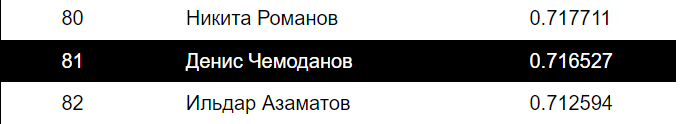